In [1]:
import os

QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99] 

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno
import pywt
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import random
import numpy as np
import torch
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, NBEATSModel, NHiTSModel, XGBModel, RNNModel, BlockRNNModel, TFTModel, TCNModel, DLinearModel, NLinearModel
from darts.models import AutoARIMA, LinearRegressionModel, RegressionEnsembleModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.metrics import mape, rmse, smape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.tuner import lr_finder
import pytorch_lightning as pl
pl.seed_everything(42, workers=True)
pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
xls = pd.ExcelFile('df_radon_combined.xlsx')

df_radon = {}
for num in xls.sheet_names[2:]:
    df_radon[num] = pd.read_excel(xls, num) 

#remove these indexes
devices = ['1', '2', '5', '9', '17', '23', '27', '28', '36', '44', '48']
for key in list(df_radon):
    if key in devices:
        del df_radon[key]

for key in df_radon:
    print(key)
    df_radon[key]['SyncDate'] = pd.to_datetime(df_radon[key]['SyncDate'])
    print(f"{df_radon[key]['SyncDate'].min()} - {df_radon[key]['SyncDate'].max()}")
    df_radon[key].sort_values(by='SyncDate', ascending=True, inplace=True)
    df_radon[key]['SyncDate'] = df_radon[key]['SyncDate'].dt.floor('H')
    df_radon[key] = df_radon[key].resample('H', on = 'SyncDate').mean()
    df_radon[key] = df_radon[key].interpolate(method='linear', limit_direction='both')
    start_time = pd.to_datetime('2022-05-11T18:29:00.000000000')
    end_time = pd.to_datetime('2023-06-06T12:00:00.000000000')
    df_radon[key] = df_radon[key][(df_radon[key].index >= start_time) & (df_radon[key].index <= end_time)]
    print(f"{df_radon[key].index.min()} - {df_radon[key].index.max()}")

3
2022-05-08 00:16:30 - 2023-06-06 12:25:38
2022-05-11 19:00:00 - 2023-06-06 12:00:00
4
2022-05-08 00:17:23 - 2023-06-06 12:26:06
2022-05-11 19:00:00 - 2023-06-06 12:00:00
7
2022-04-01 10:18:57 - 2023-06-06 12:30:25
2022-05-11 19:00:00 - 2023-06-06 12:00:00
8
2022-04-04 18:52:46 - 2023-06-06 12:27:12
2022-05-11 19:00:00 - 2023-06-06 12:00:00
10
2022-05-08 00:56:00 - 2023-06-06 23:02:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
11
2022-05-08 00:50:01 - 2023-06-07 12:13:32
2022-05-11 19:00:00 - 2023-06-06 12:00:00
13
2022-05-08 00:33:33 - 2023-06-06 23:09:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
15
2022-05-08 00:39:00 - 2023-06-06 23:59:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
16
2022-05-08 00:47:00 - 2023-06-06 23:00:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
18
2022-05-08 00:49:00 - 2023-06-06 23:07:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
19
2022-05-08 00:51:00 - 2023-06-06 23:36:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
20
2022-05-08 00:54:00 - 2023-06-07 12:40:49
20

# Radon 45

In [4]:
df = df_radon['45'].copy()

In [5]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [6]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

In [7]:
signal = df['Radon'].copy()
wavelet_name='coif9'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [8]:
weather_station = pd.read_csv('weather_data_combined.csv')

In [9]:
weather_station.drop('Date', axis=1, inplace=True)
weather_station['Simple Date'] = pd.to_datetime(weather_station['Simple Date'])
weather_station.sort_values(by='Simple Date', ascending=True, inplace=True)
weather_station['Simple Date'] = weather_station['Simple Date'].dt.floor('H')
weather_station = weather_station.resample('H', on = 'Simple Date').mean()
weather_station = weather_station.interpolate(method='linear', limit_direction='both')

In [10]:
weather_station

,Outdoor h Temperature (°F),Wind Speed (mph),Wind Gust (mph),Max Daily Gust (mph),Wind Direction (°),Hourly Rain (in/hr),Event Rain (in),Daily Rain (in),Weekly Rain (in),Monthly Rain (in),Yearly Rain (in),Relative Pressure (inHg),Humidity (%),Ultra-Violet Radiation Index,Solar Radiation (W/m^2),Absolute Pressure (inHg),Avg Wind Direction (10 mins) (°),Avg Wind Speed (10 mins) (mph)
Simple Date,,,,,,,,,,,,,,,,,,
2022-05-10 00:00:00,55.74,0.00,0.00,0.00,305.17,0.00,0.00,0.00,0.00,0.76,22.72,29.13,90.67,0.00,0.00,29.13,305.42,0.00
2022-05-10 01:00:00,54.79,0.00,0.00,0.00,302.58,0.00,0.00,0.00,0.00,0.76,22.72,29.12,91.58,0.00,0.00,29.12,302.67,0.00
2022-05-10 02:00:00,53.88,0.00,0.00,0.00,298.92,0.00,0.00,0.00,0.00,0.76,22.72,29.11,91.42,0.00,0.00,29.11,298.83,0.00
2022-05-10 03:00:00,52.49,0.00,0.00,0.00,302.92,0.00,0.00,0.00,0.00,0.76,22.72,29.12,92.83,0.00,0.00,29.12,302.83,0.00
2022-05-10 04:00:00,51.70,0.00,0.00,0.00,305.17,0.00,0.00,0.00,0.00,0.76,22.72,29.13,94.00,0.00,0.00,29.13,305.67,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-07 19:00:00,80.57,0.02,0.18,9.20,287.08,0.00,0.00,0.00,0.02,0.02,83.42,28.66,54.42,0.00,33.17,28.66,311.17,0.02
2023-06-07 20:00:00,77.16,0.00,0.00,9.20,309.83,0.00,0.00,0.00,0.02,0.02,83.42,28.66,58.42,0.00,5.92,28.66,310.00,0.00
2023-06-07 21:00:00,74.54,0.00,0.00,9.20,304.83,0.00,0.00,0.00,0.02,0.02,83.42,28.66,63.08,0.00,0.00,28.66,304.75,0.00


In [11]:
for column in weather_station.columns:
    df[column] = weather_station[column]

In [12]:
df

,AirPressure,Humidity,Radon,Temperature,Outdoor h Temperature (°F),Wind Speed (mph),Wind Gust (mph),Max Daily Gust (mph),Wind Direction (°),Hourly Rain (in/hr),...,Weekly Rain (in),Monthly Rain (in),Yearly Rain (in),Relative Pressure (inHg),Humidity (%),Ultra-Violet Radiation Index,Solar Radiation (W/m^2),Absolute Pressure (inHg),Avg Wind Direction (10 mins) (°),Avg Wind Speed (10 mins) (mph)
SyncDate,,,,,,,,,,,,,,,,,,,,,
2022-05-11 19:00:00,30.05,37.00,7.36,88.00,77.07,0.00,0.09,5.80,313.08,0.00,...,0.00,0.76,22.72,29.00,63.75,0.00,21.24,29.00,307.25,0.00
2022-05-11 20:00:00,30.05,41.00,6.93,83.00,74.87,0.00,0.00,5.80,302.08,0.00,...,0.00,0.76,22.72,29.01,68.42,0.00,2.57,29.01,301.17,0.00
2022-05-11 21:00:00,30.06,45.00,6.52,80.00,72.88,0.00,0.00,5.80,301.67,0.00,...,0.00,0.76,22.72,29.02,73.75,0.00,0.00,29.02,302.17,0.00
2022-05-11 22:00:00,30.07,49.00,6.12,77.00,71.14,0.00,0.00,5.80,306.00,0.00,...,0.00,0.76,22.72,29.05,73.75,0.00,0.00,29.05,305.83,0.00
2022-05-11 23:00:00,30.10,50.00,5.73,76.00,69.29,0.00,0.00,5.80,301.50,0.00,...,0.00,0.76,22.72,29.06,74.58,0.00,0.00,29.06,304.08,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06 08:00:00,29.89,57.50,9.67,77.00,69.51,0.29,1.03,2.25,307.83,0.00,...,0.02,0.02,83.42,28.89,86.08,0.42,104.46,28.89,307.00,0.09
2023-06-06 09:00:00,29.89,57.00,9.14,79.00,76.43,0.43,1.67,4.80,317.17,0.00,...,0.02,0.02,83.42,28.90,74.75,2.75,333.82,28.90,311.42,0.35
2023-06-06 10:00:00,29.90,49.00,8.69,86.00,81.18,0.68,2.05,6.17,308.50,0.00,...,0.02,0.02,83.42,28.89,68.08,5.00,547.11,28.89,315.25,0.57


In [13]:
df.dropna(inplace=True)

In [14]:
df

,AirPressure,Humidity,Radon,Temperature,Outdoor h Temperature (°F),Wind Speed (mph),Wind Gust (mph),Max Daily Gust (mph),Wind Direction (°),Hourly Rain (in/hr),...,Weekly Rain (in),Monthly Rain (in),Yearly Rain (in),Relative Pressure (inHg),Humidity (%),Ultra-Violet Radiation Index,Solar Radiation (W/m^2),Absolute Pressure (inHg),Avg Wind Direction (10 mins) (°),Avg Wind Speed (10 mins) (mph)
SyncDate,,,,,,,,,,,,,,,,,,,,,
2022-05-11 19:00:00,30.05,37.00,7.36,88.00,77.07,0.00,0.09,5.80,313.08,0.00,...,0.00,0.76,22.72,29.00,63.75,0.00,21.24,29.00,307.25,0.00
2022-05-11 20:00:00,30.05,41.00,6.93,83.00,74.87,0.00,0.00,5.80,302.08,0.00,...,0.00,0.76,22.72,29.01,68.42,0.00,2.57,29.01,301.17,0.00
2022-05-11 21:00:00,30.06,45.00,6.52,80.00,72.88,0.00,0.00,5.80,301.67,0.00,...,0.00,0.76,22.72,29.02,73.75,0.00,0.00,29.02,302.17,0.00
2022-05-11 22:00:00,30.07,49.00,6.12,77.00,71.14,0.00,0.00,5.80,306.00,0.00,...,0.00,0.76,22.72,29.05,73.75,0.00,0.00,29.05,305.83,0.00
2022-05-11 23:00:00,30.10,50.00,5.73,76.00,69.29,0.00,0.00,5.80,301.50,0.00,...,0.00,0.76,22.72,29.06,74.58,0.00,0.00,29.06,304.08,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06 08:00:00,29.89,57.50,9.67,77.00,69.51,0.29,1.03,2.25,307.83,0.00,...,0.02,0.02,83.42,28.89,86.08,0.42,104.46,28.89,307.00,0.09
2023-06-06 09:00:00,29.89,57.00,9.14,79.00,76.43,0.43,1.67,4.80,317.17,0.00,...,0.02,0.02,83.42,28.90,74.75,2.75,333.82,28.90,311.42,0.35
2023-06-06 10:00:00,29.90,49.00,8.69,86.00,81.18,0.68,2.05,6.17,308.50,0.00,...,0.02,0.02,83.42,28.89,68.08,5.00,547.11,28.89,315.25,0.57


In [15]:
# any missing values?
def gaps(df):
    if df.isnull().values.any():
        print("MISSING values:\n")
        mno.matrix(df)
    else:
        print("no missing values\n")
gaps(df)

no missing values



In [16]:
df.describe()

,AirPressure,Humidity,Radon,Temperature,Outdoor h Temperature (°F),Wind Speed (mph),Wind Gust (mph),Max Daily Gust (mph),Wind Direction (°),Hourly Rain (in/hr),...,Weekly Rain (in),Monthly Rain (in),Yearly Rain (in),Relative Pressure (inHg),Humidity (%),Ultra-Violet Radiation Index,Solar Radiation (W/m^2),Absolute Pressure (inHg),Avg Wind Direction (10 mins) (°),Avg Wind Speed (10 mins) (mph)
count,"9,378.00","9,378.00","9,378.00","9,378.00","9,378.00","9,378.00","9,378.00","9,378.00","9,378.00","9,378.00",...,"9,378.00","9,378.00","9,378.00","9,378.00","9,378.00","9,378.00","9,378.00","9,378.00","9,378.00","9,378.00"
mean,30.10,62.16,18.13,72.54,62.98,0.23,0.90,4.70,297.71,0.01,...,0.54,2.88,52.63,29.02,76.37,0.96,119.51,29.02,308.30,0.15
std,0.14,13.24,20.50,17.99,14.85,0.37,1.15,3.49,28.84,0.04,...,0.85,2.98,18.94,0.14,17.72,1.79,200.38,0.14,18.81,0.31
min,29.58,13.00,-0.61,15.00,7.12,0.00,0.00,0.00,1.33,0.00,...,0.00,0.00,22.72,28.40,17.17,0.00,0.00,28.40,1.42,0.00
25%,30.01,54.04,0.87,60.00,52.55,0.00,0.00,1.48,289.00,0.00,...,0.00,0.76,37.85,28.93,65.00,0.00,0.00,28.93,302.17,0.00
50%,30.10,63.00,12.20,74.00,64.87,0.03,0.37,4.50,305.58,0.00,...,0.09,2.14,47.13,29.02,79.92,0.00,2.59,29.02,311.08,0.00
75%,30.19,72.00,29.45,82.55,73.89,0.34,1.56,6.90,316.08,0.00,...,0.72,3.72,69.48,29.11,91.58,1.00,144.45,29.11,318.75,0.15
max,30.56,93.00,177.31,142.00,98.02,5.35,8.02,20.60,347.67,1.23,...,3.90,14.68,83.42,29.51,99.00,8.00,872.65,29.51,348.08,3.15


In [17]:
for column in df.columns:
    df[column] = df[column].astype('float32')
    if column == 'Radon':
        continue
    else:
        for i in range(1,40):
            df[column+'_lag_'+str(i)] = df[column].shift(i)

In [18]:
df.fillna(0, inplace=True)

In [19]:
# check correlations of features with price
df_corr = df.corr(method="spearman")
print(df_corr.shape)
print("correlation with Radon:")
df_corrP = pd.DataFrame(df_corr["Radon"].sort_values(ascending=False))
df_corrP

(841, 841)
correlation with Radon:


,Radon
Radon,1.00
Outdoor h Temperature (°F)_lag_26,0.60
Outdoor h Temperature (°F)_lag_25,0.60
Outdoor h Temperature (°F)_lag_27,0.60
Outdoor h Temperature (°F)_lag_24,0.60
...,...
Yearly Rain (in)_lag_35,-0.61
Yearly Rain (in)_lag_36,-0.61
Yearly Rain (in)_lag_37,-0.61
Yearly Rain (in)_lag_38,-0.61


In [20]:
# highest absolute correlations with Radon
pd.options.display.float_format = '{:,.2f}'.format
df_corrH = df_corrP[(df_corrP["Radon"]) >= 0.6009]
df_corrH

,Radon
Radon,1.00
Outdoor h Temperature (°F)_lag_26,0.60
Outdoor h Temperature (°F)_lag_25,0.60


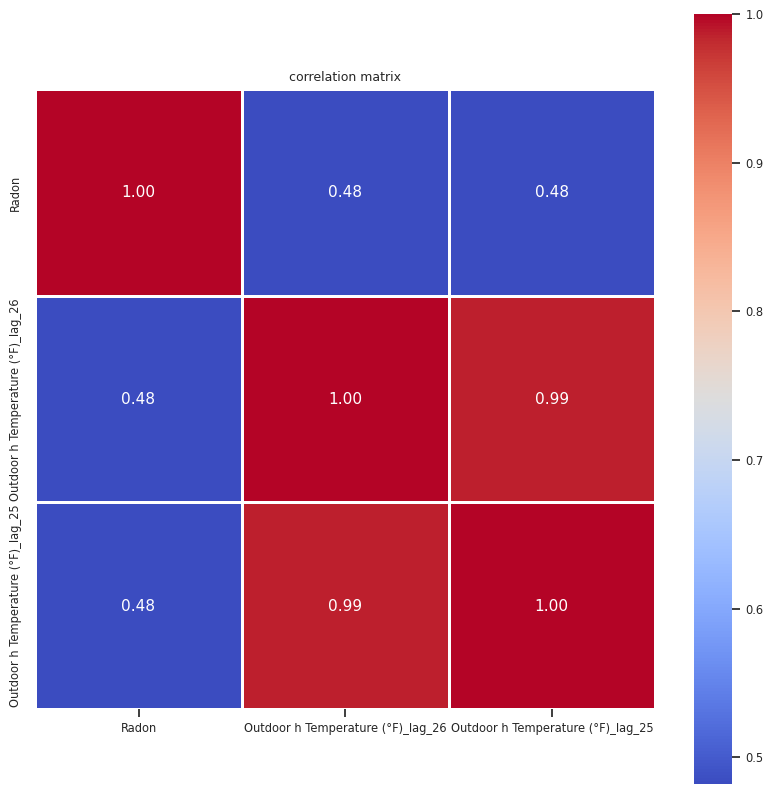

In [21]:
# helper method: correlation matrix as heatmap
def corr_heatmap(df):
    idx = df.corr().sort_values("Radon", ascending=False).index
    df_sorted = df.loc[:, idx]  # sort dataframe columns by their correlation 

    #plt.figure(figsize = (15,15))
    sns.set(font_scale=0.75)
    ax = sns.heatmap(df_sorted.corr().round(3), 
            annot=True, 
            square=True, 
            linewidths=.75, cmap="coolwarm", 
            fmt = ".2f", 
            annot_kws = {"size": 11})
    ax.xaxis.tick_bottom()
    plt.title("correlation matrix")
    plt.show()



# visualize correlations with price     

df4 = df[df_corrH.index]   # keep the components with at least modest correlations

plt.figure(figsize = (10,10))
corr_heatmap(df4)

In [22]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9378 entries, 2022-05-11 19:00:00 to 2023-06-06 12:00:00
Freq: H
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Radon                              9378 non-null   float32
 1   Outdoor h Temperature (°F)_lag_26  9378 non-null   float32
 2   Outdoor h Temperature (°F)_lag_25  9378 non-null   float32
dtypes: float32(3)
memory usage: 183.2 KB


In [23]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df4["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [24]:
# create time series object for the feature columns
df_covF = df4.loc[:, df4.columns != "Radon"]
df_covF = df_covF.loc[:, df_covF.columns != 'Outdoor h Temperature (°F)_lag_25']
ts_covF = TimeSeries.from_dataframe(df_covF, fill_missing_dates=True, freq="H")

# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)

components (columns) of feature time series: Index(['Outdoor h Temperature (°F)_lag_26'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [25]:
# example: operating with time series objects:
# we can also create a 3-dimensional numpy array from a time series object
# 3 dimensions: time (rows) / components (columns) / samples
ar_covF = ts_covF.all_values()
print(type(ar_covF))
ar_covF.shape

<class 'numpy.ndarray'>


(9378, 1, 1)

In [26]:
# example: operating with time series objects:
# we can also create a pandas series or dataframe from a time series object
df_covF = ts_covF.pd_dataframe()
type(df_covF)

pandas.core.frame.DataFrame

In [27]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component,Radon
SyncDate,
2022-05-11 19:00:00,0.04
2023-06-06 12:00:00,0.05


In [28]:
# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(split_point=9210)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  
# covF_t = ts_covF
# covF_ttrain = covF_train
# covF_ttest = covF_test
# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component,Outdoor h Temperature (°F)_lag_26
SyncDate,
2022-05-11 19:00:00,0.00
2023-06-06 12:00:00,0.70


In [29]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component,Radon
SyncDate,
2022-05-11 19:00:00,0.04
2023-05-30 13:00:00,0.07


In [30]:
def set_seed(seed_value):
    import random
    import numpy as np
    import torch

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    pl.seed_everything(seed_value, workers=True)

In [31]:
import torch
from ray.air import session
from darts.utils.losses import SmapeLoss
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError
def build_fit_nlinear_model(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1
    set_seed(42)
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":-1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
    encoders={"cyclic": {"future": ["hour"]},
             'transformer':Scaler()} if model_args['include_hour'] else None
   

    model = NLinearModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="NLinear",
        shared_weights=False,
        normalize=model_args['normalize'],
        const_init=model_args['const_init'],
        use_static_covariates=False,
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        add_encoders=encoders,
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                future_covariates=covF_t,
                val_series=val_series,
                val_future_covariates=covF_t,)
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
    ts_tpred = model.predict(
                series = ts_ttrain,
                future_covariates=covF_t,
                n = len(ts_ttest),
                verbose=True
    )
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    session.report({'q_smape': q_smape})

In [32]:
def build_fit_nlinear_model_return(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1
    set_seed(42)
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "devices":1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": True,
        }
    encoders={"cyclic": {"future": ["hour"]},
             'transformer':Scaler()} if model_args['include_hour'] else None
   

    model = NLinearModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="DLinear",
        shared_weights=False,
        const_init=model_args['const_init'],
        normalize=model_args['normalize'],
        use_static_covariates=False,
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        add_encoders=encoders,
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                future_covariates=covF_t,
                val_series=val_series,
                val_future_covariates=covF_t,)
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
#     ts_tpred = model.predict(
#                 series = ts_ttrain,
#                 past_covariates=covF_t,
#                 n = len(ts_ttest),
#                 verbose=True
#     )
#     ts_q = scalerP.inverse_transform(ts_tpred)
#     q_smape = smape(ts_q, ts_test)
#     session.report({'q_smape': q_smape})
    return model

In [33]:
from ray import tune
from ray.tune import CLIReporter
# from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":"val_loss",
#         "sMAPE": "val_SymmetricMeanAbsolutePercentageError",
#     },
#     on="validation_end",
# )

early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )

#define the hyperparameter search space
config = {
    "in_len": tune.randint(8,168),#setting 168 is not a good option here as convolutions take time reducing this to 80
    "out_len":tune.randint(1,24),
    "normalize": tune.choice([True, False]),
    "const_init":tune.choice([True, False]),
    "lr": tune.loguniform(1e-5, 1e-1),
    "include_hour":tune.choice([True, False]),
    "batch_size":tune.choice([16,32,64,128,256]),
    
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape"])
resources_per_trial = {"cpu": 5, "gpu": 0.4}

num_samples = 100

algo = OptunaSearch()

algo = ConcurrencyLimiter(algo, max_concurrent=10)

scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_nlinear_model, callbacks=[early_stopper])

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric="q_smape",
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="dlinear_tune_cov",
    raise_on_failed_trial=False
)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-11 07:54:10 (running for 00:00:00.18)
Memory usage on this node: 88.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 1/100 (1 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr | include_hour   |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------|
| build_fit_nlinear_model_cb252c9a | RUNN

(build_fit_nlinear_model pid=2659586) Global seed set to 42
(build_fit_nlinear_model pid=2659586) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2659586)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2659586) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2659586)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2659586) Auto select gpus: [0]
(build_fit_nlinear_model pid=2659586) GPU available: 

== Status ==
Current time: 2023-07-11 07:54:15 (running for 00:00:05.20)
Memory usage on this node: 88.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 2/100 (2 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr | include_hour   |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------|
| build_fit_nlinear_model_cb252c9a | RUN

(build_fit_nlinear_model pid=2659835) Global seed set to 42
(build_fit_nlinear_model pid=2659835) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2659835)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2659835) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2659835)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2659835) Auto select gpus: [0]
(build_fit_nlinear_model pid=2659835) GPU available: 

== Status ==
Current time: 2023-07-11 07:54:20 (running for 00:00:10.27)
Memory usage on this node: 89.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 3/100 (3 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr | include_hour   |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------|
| build_fit_nlinear_model

Trial name,date,experiment_id,hostname,node_ip,pid,timestamp,trial_id
build_fit_nlinear_model_03542bb7,2023-07-11_07-57-04,1a5f3dceb51e44d7bafda45898a530b1,ip-172-31-10-87,172.31.10.87,2674221,1689062224,03542bb7
build_fit_nlinear_model_06c8d9a1,2023-07-11_07-56-49,c8eb9222566542b7bfb018cdee9b66db,ip-172-31-10-87,172.31.10.87,2668469,1689062209,06c8d9a1
build_fit_nlinear_model_0a369a68,2023-07-11_07-56-01,08336a4671e4463cb764e59976702b18,ip-172-31-10-87,172.31.10.87,2669339,1689062161,0a369a68
build_fit_nlinear_model_0f3a7ae8,2023-07-11_07-54-32,1eb8a488584b4e1a8daefa44173a3e50,ip-172-31-10-87,172.31.10.87,2660925,1689062072,0f3a7ae8
build_fit_nlinear_model_112beeb4,2023-07-11_07-58-11,1c3e7072408b4dc6a2443560948c4866,ip-172-31-10-87,172.31.10.87,2683112,1689062291,112beeb4
build_fit_nlinear_model_12f2a79e,2023-07-11_07-54-31,e61a4b19e8b44d6397c6543744b4a41e,ip-172-31-10-87,172.31.10.87,2660913,1689062071,12f2a79e
build_fit_nlinear_model_15b489a7,2023-07-11_07-57-22,3160a068c3ba457a8f5093a4026e5b3b,ip-172-31-10-87,172.31.10.87,2675636,1689062242,15b489a7
build_fit_nlinear_model_17cb88ed,2023-07-11_07-57-38,ac9b76d5a64e472a81d41d5ddaf1aed5,ip-172-31-10-87,172.31.10.87,2678200,1689062258,17cb88ed
build_fit_nlinear_model_1a719bad,2023-07-11_07-56-54,41aeca489e6a4beb913304ec27c87bfd,ip-172-31-10-87,172.31.10.87,2673113,1689062214,1a719bad
build_fit_nlinear_model_1b932dac,2023-07-11_07-56-18,c316e7d45b9d4ba9b5d622033fa1196b,ip-172-31-10-87,172.31.10.87,2671114,1689062178,1b932dac


== Status ==
Current time: 2023-07-11 07:54:26 (running for 00:00:15.76)
Memory usage on this node: 89.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 4/100 (1 ERROR, 1 PENDING, 2 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr | include_hour   |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------|
| build_fit_nlinear_

(build_fit_nlinear_model pid=2660277) Global seed set to 42
(build_fit_nlinear_model pid=2660277) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2660277)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2660277) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2660277)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2660277) Auto select gpus: [0]
(build_fit_nlinear_model pid=2660277) GPU available: 

== Status ==
Current time: 2023-07-11 07:54:31 (running for 00:00:20.88)
Memory usage on this node: 91.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 10/100 (1 ERROR, 1 PENDING, 8 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr | include_hour   |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------|
| bu

(build_fit_nlinear_model pid=2660923) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2660923)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2660923) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2660923)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2660921) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecat

(build_fit_nlinear_model pid=2660925) Auto select gpus: [0]
(build_fit_nlinear_model pid=2660925) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2660925) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2660925) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2660925) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2660925) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2660925) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2660925) 
(build_fit_nlinear_model pid=2660925)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2660925) ----

== Status ==
Current time: 2023-07-11 07:54:36 (running for 00:00:26.35)
Memory usage on this node: 93.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 13/100 (5 ERROR, 8 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr | include_hour   |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------|
| build_fit_nli

(build_fit_nlinear_model pid=2663300) Global seed set to 42
(build_fit_nlinear_model pid=2663300) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2663300)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2663300) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2663300)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2662821) Auto select gpus: [0]
(build_fit_nlinear_model pid=2662821) GPU available: 

(build_fit_nlinear_model pid=2662819) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2662819)   rank_zero_warn(
(build_fit_nlinear_model pid=2662819) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2662819)   rank_zero_warn(
(build_fit_nlinear_model pid=2662819) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

== Status ==
Current time: 2023-07-11 07:54:48 (running for 00:00:37.77)
Memory usage on this node: 99.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 14/100 (5 ERROR, 1 PENDING, 8 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr | include_hour   |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------|
| bu

(build_fit_nlinear_model pid=2660923) Auto select gpus: [0]
(build_fit_nlinear_model pid=2660923) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2660923) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2660923) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2660923) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2660923) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2660923) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 229.49it/s]


(build_fit_nlinear_model pid=2660921) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2660921)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2660921) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2660921)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2660921) Auto select gpus: [0]
(build_fit_nlinear_model pid=2660921) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2660921

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.80it/s]


(build_fit_nlinear_model pid=2664634) Global seed set to 42
(build_fit_nlinear_model pid=2664634) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2664634)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2664634) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2664634)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2664634) Auto select gpus: [0]
(build_fit_nlinear_model pid=2664634) GPU available: 

== Status ==
Current time: 2023-07-11 07:55:01 (running for 00:00:51.37)
Memory usage on this node: 100.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 85c62b7a with q_smape=108.20406675338745 and parameters={'in_len': 154, 'out_len': 20, 'normalize': False, 'const_init': False, 'lr': 9.403939261939506e-05, 'include_hour': False, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 16/100 (5 ERROR, 1 PENDING, 8 RUNNING, 2 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len 

(build_fit_nlinear_model pid=2664804) Global seed set to 42
(build_fit_nlinear_model pid=2664804) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2664804)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2664804) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2664804)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2664804) Auto select gpus: [0]
(build_fit_nlinear_model pid=2664804) GPU available: 

== Status ==
Current time: 2023-07-11 07:55:09 (running for 00:00:59.36)
Memory usage on this node: 103.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 85c62b7a with q_smape=108.20406675338745 and parameters={'in_len': 154, 'out_len': 20, 'normalize': False, 'const_init': False, 'lr': 9.403939261939506e-05, 'include_hour': False, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 17/100 (6 ERROR, 1 PENDING, 8 RUNNING, 2 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len 

(build_fit_nlinear_model pid=2665279) Global seed set to 42
(build_fit_nlinear_model pid=2665279) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2665279)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2665279) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2665279)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2665279) Auto select gpus: [0]
(build_fit_nlinear_model pid=2665279) GPU available: 

== Status ==
Current time: 2023-07-11 07:55:17 (running for 00:01:07.37)
Memory usage on this node: 101.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 85c62b7a with q_smape=108.20406675338745 and parameters={'in_len': 154, 'out_len': 20, 'normalize': False, 'const_init': False, 'lr': 9.403939261939506e-05, 'include_hour': False, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 18/100 (7 ERROR, 1 PENDING, 8 RUNNING, 2 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len 

(build_fit_nlinear_model pid=2665601) Global seed set to 42
(build_fit_nlinear_model pid=2665601) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2665601)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2665601) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2665601)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2665601) Auto select gpus: [0]
(build_fit_nlinear_model pid=2665601) GPU available: 

== Status ==
Current time: 2023-07-11 07:55:27 (running for 00:01:17.37)
Memory usage on this node: 103.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 85c62b7a with q_smape=108.20406675338745 and parameters={'in_len': 154, 'out_len': 20, 'normalize': False, 'const_init': False, 'lr': 9.403939261939506e-05, 'include_hour': False, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 19/100 (8 ERROR, 1 PENDING, 8 RUNNING, 2 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len 

(build_fit_nlinear_model pid=2666083) Global seed set to 42
(build_fit_nlinear_model pid=2666083) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2666083)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2666083) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2666083)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2666083) Auto select gpus: [0]
(build_fit_nlinear_model pid=2666083) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.87it/s]


(build_fit_nlinear_model pid=2662821) Auto select gpus: [0]
(build_fit_nlinear_model pid=2662821) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2662821) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2662821) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2662821) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2662821) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2662821) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 251.43it/s]


(build_fit_nlinear_model pid=2663300) Auto select gpus: [0]
(build_fit_nlinear_model pid=2663300) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2663300) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2663300) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2663300) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2663300) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2663300) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-11 07:55:33 (running for 00:01:23.66)
Memory usage on this node: 101.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4acdf74f with q_smape=73.27857613563538 and parameters={'in_len': 107, 'out_len': 21, 'normalize': False, 'const_init': False, 'lr': 0.000176996078925303, 'include_hour': False, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 20/100 (8 ERROR, 1 PENDING, 8 RUNNING, 3 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | 

(build_fit_nlinear_model pid=2666500) Global seed set to 42
(build_fit_nlinear_model pid=2666500) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2666500)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2666500) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2666500)   rank_zero_deprecation(


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nlinear_model pid=2662823) Auto select gpus: [0]
(build_fit_nlinear_model pid=2662823) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2662823) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2662823) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2662823) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2662823) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2662823) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2666500) Auto select gpus: [0]
(build_fit_nlinear_model pid=2666500) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.55it/s]


(build_fit_nlinear_model pid=2662819) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2662819)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2662819) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2662819)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2662819) Auto select gpus: [0]
(build_fit_nlinear_model pid=2662819) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2662819

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.31it/s]
== Status ==
Current time: 2023-07-11 07:55:40 (running for 00:01:29.92)
Memory usage on this node: 96.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4acdf74f with q_smape=73.27857613563538 and parameters={'in_len': 107, 'out_len': 21, 'normalize': False, 'const_init': False, 'lr': 0.000176996078925303, 'include_hour': False, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (8 ERROR, 1 PENDING, 8 RUNNING, 4 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name             

(build_fit_nlinear_model pid=2667086) Global seed set to 42
(build_fit_nlinear_model pid=2667086) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2667086)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2667086) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2667086)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2667086) Auto select gpus: [0]
(build_fit_nlinear_model pid=2667086) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 208.24it/s]


(build_fit_nlinear_model pid=2660277) Auto select gpus: [0]
(build_fit_nlinear_model pid=2660277) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2660277) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2660277) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2660277) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2660277) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2660277) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-11 07:55:46 (running for 00:01:36.36)
Memory usage on this node: 92.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4acdf74f with q_smape=73.27857613563538 and parameters={'in_len': 107, 'out_len': 21, 'normalize': False, 'const_init': False, 'lr': 0.000176996078925303, 'include_hour': False, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (9 ERROR, 6 RUNNING, 6 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   

(build_fit_nlinear_model pid=2667996) Global seed set to 42


== Status ==
Current time: 2023-07-11 07:55:51 (running for 00:01:41.70)
Memory usage on this node: 94.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4acdf74f with q_smape=73.27857613563538 and parameters={'in_len': 107, 'out_len': 21, 'normalize': False, 'const_init': False, 'lr': 0.000176996078925303, 'include_hour': False, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 22/100 (10 ERROR, 1 PENDING, 5 RUNNING, 6 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | c

(build_fit_nlinear_model pid=2667996) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2667996)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2667996) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2667996)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2667996) Auto select gpus: [0]
(build_fit_nlinear_model pid=2667996) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2667996

(build_fit_nlinear_model pid=2668478) Auto select gpus: [0]
(build_fit_nlinear_model pid=2668478) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2668478) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2668478) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2668478) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2668478) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2668478) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2668478) 
(build_fit_nlinear_model pid=2668478)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2668478) ----

== Status ==
Current time: 2023-07-11 07:56:00 (running for 00:01:50.38)
Memory usage on this node: 96.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4acdf74f with q_smape=73.27857613563538 and parameters={'in_len': 107, 'out_len': 21, 'normalize': False, 'const_init': False, 'lr': 0.000176996078925303, 'include_hour': False, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 27/100 (11 ERROR, 1 PENDING, 8 RUNNING, 7 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | 

(build_fit_nlinear_model pid=2669339) Global seed set to 42
(build_fit_nlinear_model pid=2668469) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2668469)   rank_zero_warn(
(build_fit_nlinear_model pid=2668469) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2668469)   rank_zero_warn(
(build_fit_nlinear_model pid=2669339) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1

(build_fit_nlinear_model pid=2670113) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2670113)   rank_zero_warn(
(build_fit_nlinear_model pid=2670113) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2670113)   rank_zero_warn(
(build_fit_nlinear_model pid=2670276) Auto select gpus: [0]
(build_fit_nlinear_model pid=2670276) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2670276) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2670276) IPU available: 

== Status ==
Current time: 2023-07-11 07:56:09 (running for 00:01:59.39)
Memory usage on this node: 100.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4acdf74f with q_smape=73.27857613563538 and parameters={'in_len': 107, 'out_len': 21, 'normalize': False, 'const_init': False, 'lr': 0.000176996078925303, 'include_hour': False, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 30/100 (14 ERROR, 1 PENDING, 8 RUNNING, 7 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len |

(build_fit_nlinear_model pid=2670503) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2670503)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2670503) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2670503)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2670276) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbs

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 235.42it/s]


(build_fit_nlinear_model pid=2671114) Global seed set to 42
(build_fit_nlinear_model pid=2671114) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2671114)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2671114) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2671114)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 07:56:18 (running for 00:02:08.38)
Memory usage on this node: 97.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ba05bef5 with q_smape=68.18698644638062 and parameters={'in_len': 114, 'out_len': 15, 'normalize': False, 'const_init': False, 'lr': 0.0006511575404038469, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 32/100 (15 ERROR, 1 PENDING, 8 RUNNING, 8 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | 

(build_fit_nlinear_model pid=2671273) Global seed set to 42
(build_fit_nlinear_model pid=2671273) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2671273)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2671273) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2671273)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2671114) Auto select gpus: [0]
(build_fit_nlinear_model pid=2671114) GPU available: 

== Status ==
Current time: 2023-07-11 07:56:27 (running for 00:02:17.39)
Memory usage on this node: 95.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ba05bef5 with q_smape=68.18698644638062 and parameters={'in_len': 114, 'out_len': 15, 'normalize': False, 'const_init': False, 'lr': 0.0006511575404038469, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 34/100 (17 ERROR, 1 PENDING, 8 RUNNING, 8 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | 

(build_fit_nlinear_model pid=2671993) Global seed set to 42
(build_fit_nlinear_model pid=2671993) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2671993)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2671993) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2671993)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2671836) Auto select gpus: [0]
(build_fit_nlinear_model pid=2671836) GPU available: 

== Status ==
Current time: 2023-07-11 07:56:32 (running for 00:02:22.63)
Memory usage on this node: 99.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ba05bef5 with q_smape=68.18698644638062 and parameters={'in_len': 114, 'out_len': 15, 'normalize': False, 'const_init': False, 'lr': 0.0006511575404038469, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 34/100 (17 ERROR, 1 PENDING, 8 RUNNING, 8 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | 

(build_fit_nlinear_model pid=2670113) Auto select gpus: [0]
(build_fit_nlinear_model pid=2670113) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2670113) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2670113) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2670113) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2670113) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2670113) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.67it/s]
== Status ==
Current time: 2023-07-11 07:56:39 (running for 00:02:29.39)
Memory usage on this node: 95.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ba05bef5 with q_smape=68.18698644638062 and parameters={'in_len': 114, 'out_len': 15, 'normalize': False, 'const_init': False, 'lr': 0.0006511575404038469, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 35/100 (17 ERROR, 1 PENDING, 8 RUNNING, 9 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name             

(build_fit_nlinear_model pid=2672409) Global seed set to 42
(build_fit_nlinear_model pid=2672409) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2672409)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2672409) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2672409)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2672409) Auto select gpus: [0]
(build_fit_nlinear_model pid=2672409) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.00it/s]
== Status ==
Current time: 2023-07-11 07:56:47 (running for 00:02:37.06)
Memory usage on this node: 90.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ba05bef5 with q_smape=68.18698644638062 and parameters={'in_len': 114, 'out_len': 15, 'normalize': False, 'const_init': False, 'lr': 0.0006511575404038469, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 36/100 (18 ERROR, 1 PENDING, 8 RUNNING, 9 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name            

(build_fit_nlinear_model pid=2672702) Global seed set to 42
(build_fit_nlinear_model pid=2672702) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2672702)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2672702) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2672702)   rank_zero_deprecation(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 208.04it/s]


(build_fit_nlinear_model pid=2668469) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2668469)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2668469) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2668469)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2668469) Auto select gpus: [0]
(build_fit_nlinear_model pid=2668469) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2668469

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.52it/s]


(build_fit_nlinear_model pid=2672702) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2672702)   rank_zero_warn(
(build_fit_nlinear_model pid=2672702) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2672702)   rank_zero_warn(
(build_fit_nlinear_model pid=2672702) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

== Status ==
Current time: 2023-07-11 07:56:54 (running for 00:02:44.44)
Memory usage on this node: 89.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ba05bef5 with q_smape=68.18698644638062 and parameters={'in_len': 114, 'out_len': 15, 'normalize': False, 'const_init': False, 'lr': 0.0006511575404038469, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 39/100 (18 ERROR, 1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len |

(build_fit_nlinear_model pid=2673283) Global seed set to 42
(build_fit_nlinear_model pid=2673285) Global seed set to 42
(build_fit_nlinear_model pid=2673283) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2673283)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2673283) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2673283)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2673285) /home/ubuntu/an

(build_fit_nlinear_model pid=2673910) Global seed set to 42
(build_fit_nlinear_model pid=2673908) Global seed set to 42
(build_fit_nlinear_model pid=2673908) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2673908)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2673908) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2673908)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2673910) /home/ubuntu/an

== Status ==
Current time: 2023-07-11 07:57:03 (running for 00:02:53.40)
Memory usage on this node: 89.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ba05bef5 with q_smape=68.18698644638062 and parameters={'in_len': 114, 'out_len': 15, 'normalize': False, 'const_init': False, 'lr': 0.0006511575404038469, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 42/100 (21 ERROR, 1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len |

(build_fit_nlinear_model pid=2674221) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2674221)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2674221) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2674221)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2673910) Auto select gpus: [0]
(build_fit_nlinear_model pid=2673910) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2673910

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.14it/s]


(build_fit_nlinear_model pid=2674689) Global seed set to 42
(build_fit_nlinear_model pid=2674689) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2674689)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2674689) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2674689)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2674849) Global seed set to 42
(build_fit_nlinear_model pid=2674849) /home/ubuntu/an

== Status ==
Current time: 2023-07-11 07:57:13 (running for 00:03:03.40)
Memory usage on this node: 89.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ba05bef5 with q_smape=68.18698644638062 and parameters={'in_len': 114, 'out_len': 15, 'normalize': False, 'const_init': False, 'lr': 0.0006511575404038469, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 46/100 (24 ERROR, 1 PENDING, 8 RUNNING, 13 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len |

(build_fit_nlinear_model pid=2675166) Global seed set to 42
(build_fit_nlinear_model pid=2675166) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2675166)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2675166) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2675166)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2674849) Auto select gpus: [0]
(build_fit_nlinear_model pid=2674849) GPU available: 

(build_fit_nlinear_model pid=2671993) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2671993) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2671993) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2671993) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2671993) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2671993) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.11it/s]


(build_fit_nlinear_model pid=2675636) Global seed set to 42
(build_fit_nlinear_model pid=2675634) Global seed set to 42
(build_fit_nlinear_model pid=2675634) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2675634)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2675634) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2675634)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2675636) /home/ubuntu/an

== Status ==
Current time: 2023-07-11 07:57:23 (running for 00:03:13.40)
Memory usage on this node: 86.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: feb74060 with q_smape=50.491225719451904 and parameters={'in_len': 146, 'out_len': 9, 'normalize': False, 'const_init': True, 'lr': 5.047694155596576e-05, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 51/100 (28 ERROR, 1 PENDING, 8 RUNNING, 14 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | 

(build_fit_nlinear_model pid=2675634) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2675634) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2675634) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2675634) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2675634) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2675634) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2675634) 
(build_fit_nlinear_model pid=2675634)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2675634) ----------------------------------------------------
(build_fit_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.50it/s]


(build_fit_nlinear_model pid=2672702) Auto select gpus: [0]
(build_fit_nlinear_model pid=2672702) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2672702) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2672702) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2672702) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2672702) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2672702) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2676966) Global seed set to 42
(build_fit_nlinear_model pid=2676966) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 07:57:29 (running for 00:03:19.43)
Memory usage on this node: 81.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: feb74060 with q_smape=50.491225719451904 and parameters={'in_len': 146, 'out_len': 9, 'normalize': False, 'const_init': True, 'lr': 5.047694155596576e-05, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 56/100 (33 ERROR, 1 PENDING, 8 RUNNING, 14 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | 

(build_fit_nlinear_model pid=2677019) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2677019)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2677019) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2677019)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2677069) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecat

(build_fit_nlinear_model pid=2676968) Auto select gpus: [0]
(build_fit_nlinear_model pid=2676968) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2676968) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2676968) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2676968) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2676968) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2676968) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2676968) 
(build_fit_nlinear_model pid=2676968)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2676968) ----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.13it/s]


(build_fit_nlinear_model pid=2666083) Auto select gpus: [0]
(build_fit_nlinear_model pid=2666083) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2666083) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2666083) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2666083) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2666083) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2666083) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-11 07:57:35 (running for 00:03:24.77)
Memory usage on this node: 87.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: feb74060 with q_smape=50.491225719451904 and parameters={'in_len': 146, 'out_len': 9, 'normalize': False, 'const_init': True, 'lr': 5.047694155596576e-05, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 57/100 (34 ERROR, 1 PENDING, 7 RUNNING, 15 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | c

(build_fit_nlinear_model pid=2678200) Global seed set to 42
(build_fit_nlinear_model pid=2678200) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2678200)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2678200) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2678200)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2678200) Auto select gpus: [0]
(build_fit_nlinear_model pid=2678200) GPU available: 

== Status ==
Current time: 2023-07-11 07:57:41 (running for 00:03:30.83)
Memory usage on this node: 80.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: feb74060 with q_smape=50.491225719451904 and parameters={'in_len': 146, 'out_len': 9, 'normalize': False, 'const_init': True, 'lr': 5.047694155596576e-05, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 63/100 (39 ERROR, 1 PENDING, 7 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | c

(build_fit_nlinear_model pid=2678738) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2678738)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2678738) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2678738)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2678787) Global seed set to 42
(build_fit_nlinear_model pid=2678689) Global seed set to 42
(build_fit_nlinear_model pid=2678789) /home/ubuntu/an

(build_fit_nlinear_model pid=2678787) Auto select gpus: [0]
(build_fit_nlinear_model pid=2678787) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2678787) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2678787) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2678787) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2678787) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2678787) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2678787) 
(build_fit_nlinear_model pid=2678787)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2678787) ----

== Status ==
Current time: 2023-07-11 07:57:46 (running for 00:03:36.57)
Memory usage on this node: 89.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: feb74060 with q_smape=50.491225719451904 and parameters={'in_len': 146, 'out_len': 9, 'normalize': False, 'const_init': True, 'lr': 5.047694155596576e-05, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 64/100 (40 ERROR, 1 PENDING, 7 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | c

(build_fit_nlinear_model pid=2680055) Global seed set to 42
(build_fit_nlinear_model pid=2680055) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2680055)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2680055) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2680055)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2680055) Auto select gpus: [0]
(build_fit_nlinear_model pid=2680055) GPU available: 

== Status ==
Current time: 2023-07-11 07:57:52 (running for 00:03:42.49)
Memory usage on this node: 80.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: feb74060 with q_smape=50.491225719451904 and parameters={'in_len': 146, 'out_len': 9, 'normalize': False, 'const_init': True, 'lr': 5.047694155596576e-05, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 70/100 (46 ERROR, 1 PENDING, 7 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | c

(build_fit_nlinear_model pid=2680320) Global seed set to 42
(build_fit_nlinear_model pid=2680320) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2680320)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2680320) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2680320)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2680373) Auto select gpus: [0]
(build_fit_nlinear_model pid=2680373) GPU available: 

(build_fit_nlinear_model pid=2680422) Auto select gpus: [0]
(build_fit_nlinear_model pid=2680422) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2680422) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2680422) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2680422) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2680422) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2680422) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2680422) 
(build_fit_nlinear_model pid=2680422)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2680422) ----

== Status ==
Current time: 2023-07-11 07:57:58 (running for 00:03:48.39)
Memory usage on this node: 85.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: feb74060 with q_smape=50.491225719451904 and parameters={'in_len': 146, 'out_len': 9, 'normalize': False, 'const_init': True, 'lr': 5.047694155596576e-05, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 70/100 (46 ERROR, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize  

(build_fit_nlinear_model pid=2681858) Global seed set to 42
(build_fit_nlinear_model pid=2681858) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2681858)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2681858) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2681858)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 07:58:03 (running for 00:03:53.41)
Memory usage on this node: 86.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: feb74060 with q_smape=50.491225719451904 and parameters={'in_len': 146, 'out_len': 9, 'normalize': False, 'const_init': True, 'lr': 5.047694155596576e-05, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 71/100 (52 ERROR, 1 PENDING, 2 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | c

(build_fit_nlinear_model pid=2681858) Auto select gpus: [0]
(build_fit_nlinear_model pid=2681858) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2681858) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2681858) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2681858) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2681858) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2681858) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2681858) 
(build_fit_nlinear_model pid=2681858)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2681858) ----

(build_fit_nlinear_model pid=2682184) Auto select gpus: [0]
(build_fit_nlinear_model pid=2682184) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2682184) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2682184) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2682184) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2682184) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2682184) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2682184) 
(build_fit_nlinear_model pid=2682184)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2682184) ----

== Status ==
Current time: 2023-07-11 07:58:11 (running for 00:04:01.41)
Memory usage on this node: 86.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: feb74060 with q_smape=50.491225719451904 and parameters={'in_len': 146, 'out_len': 9, 'normalize': False, 'const_init': True, 'lr': 5.047694155596576e-05, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 78/100 (54 ERROR, 1 PENDING, 7 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | c

(build_fit_nlinear_model pid=2683112) Global seed set to 42
(build_fit_nlinear_model pid=2683112) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2683112)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2683112) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2683112)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2683112) Auto select gpus: [0]
(build_fit_nlinear_model pid=2683112) GPU available: 

(build_fit_nlinear_model pid=2683805) Auto select gpus: [0]
(build_fit_nlinear_model pid=2683805) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2683805) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2683805) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2683805) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2683805) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2683805) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2683805) 
(build_fit_nlinear_model pid=2683805)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2683805) ----

(build_fit_nlinear_model pid=2684289) Auto select gpus: [0]
(build_fit_nlinear_model pid=2684289) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2684289) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2684289) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2684289) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2684289) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2684289) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2684289) 
(build_fit_nlinear_model pid=2684289)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2684289) ----

== Status ==
Current time: 2023-07-11 07:58:20 (running for 00:04:10.41)
Memory usage on this node: 78.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: feb74060 with q_smape=50.491225719451904 and parameters={'in_len': 146, 'out_len': 9, 'normalize': False, 'const_init': True, 'lr': 5.047694155596576e-05, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 85/100 (60 ERROR, 1 PENDING, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | 

(build_fit_nlinear_model pid=2684740) Global seed set to 42
(build_fit_nlinear_model pid=2684740) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2684740)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2684740) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2684740)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2684740) Auto select gpus: [0]
(build_fit_nlinear_model pid=2684740) GPU available: 

(build_fit_nlinear_model pid=2685757) Auto select gpus: [0]
(build_fit_nlinear_model pid=2685757) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2685757) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2685757) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2685757) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2685757) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2685757) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2685757) 
(build_fit_nlinear_model pid=2685757)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2685757) ----

(build_fit_nlinear_model pid=2686364) Auto select gpus: [0]
(build_fit_nlinear_model pid=2686364) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2686364) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2686364) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2686364) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2686364) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2686364) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2686364) 
(build_fit_nlinear_model pid=2686364)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2686364) ----

== Status ==
Current time: 2023-07-11 07:58:29 (running for 00:04:19.25)
Memory usage on this node: 83.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: feb74060 with q_smape=50.491225719451904 and parameters={'in_len': 146, 'out_len': 9, 'normalize': False, 'const_init': True, 'lr': 5.047694155596576e-05, 'include_hour': True, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 92/100 (68 ERROR, 1 PENDING, 7 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | c

(build_fit_nlinear_model pid=2686802) Global seed set to 42
(build_fit_nlinear_model pid=2686802) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2686802)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2686802) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2686802)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2686802) Auto select gpus: [0]
(build_fit_nlinear_model pid=2686802) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 272.91it/s]


(build_fit_nlinear_model pid=2659586) Auto select gpus: [0]
(build_fit_nlinear_model pid=2659586) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2659586) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2659586) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2659586) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2659586) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2659586) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2687676) Global seed set to 42
(build_fit_nlinear_model pid=2687625) Global seed set to 42
(build_fit_nlinear_model pid=2687625) /home/ub

(build_fit_nlinear_model pid=2687574) Auto select gpus: [0]
(build_fit_nlinear_model pid=2687574) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2687574) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2687574) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2687574) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2687574) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2687574) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2687574) 
(build_fit_nlinear_model pid=2687574)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2687574) ----

(build_fit_nlinear_model pid=2688503) Global seed set to 42
(build_fit_nlinear_model pid=2688503) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2688503)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2688503) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2688503)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 07:58:34 (running for 00:04:24.40)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cb252c9a with q_smape=22.97404855489731 and parameters={'in_len': 64, 'out_len': 22, 'normalize': False, 'const_init': False, 'lr': 0.00014381783179778651, 'include_hour': False, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 99/100 (74 ERROR, 8 RUNNING, 17 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize 

(build_fit_nlinear_model pid=2688664) Global seed set to 42


== Status ==
Current time: 2023-07-11 07:58:39 (running for 00:04:29.46)
Memory usage on this node: 80.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cb252c9a with q_smape=22.97404855489731 and parameters={'in_len': 64, 'out_len': 22, 'normalize': False, 'const_init': False, 'lr': 0.00014381783179778651, 'include_hour': False, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (75 ERROR, 1 PENDING, 7 RUNNING, 17 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   |

(build_fit_nlinear_model pid=2688664) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2688664)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2688664) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2688664)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2688503) Auto select gpus: [0]
(build_fit_nlinear_model pid=2688503) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2688503

== Status ==
Current time: 2023-07-11 07:58:47 (running for 00:04:37.04)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cb252c9a with q_smape=22.97404855489731 and parameters={'in_len': 64, 'out_len': 22, 'normalize': False, 'const_init': False, 'lr': 0.00014381783179778651, 'include_hour': False, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (82 ERROR, 1 RUNNING, 17 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init 

== Status ==
Current time: 2023-07-11 07:58:47 (running for 00:04:37.25)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/48 CPUs, 0/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cb252c9a with q_smape=22.97404855489731 and parameters={'in_len': 64, 'out_len': 22, 'normalize': False, 'const_init': False, 'lr': 0.00014381783179778651, 'include_hour': False, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (83 ERROR, 17 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr

In [34]:
analysis.best_config

{'in_len': 64,
 'out_len': 22,
 'normalize': False,
 'const_init': False,
 'lr': 0.00014381783179778651,
 'include_hour': False,
 'batch_size': 64}

In [35]:
early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )
best_model = build_fit_nlinear_model_return(analysis.best_config, callbacks=[early_stopper])

/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  rank_zero_deprecation(


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [36]:
ts_tpred = best_model.predict(
                series = ts_ttrain,
                future_covariates=covF_t,
                n = len(ts_ttest),
                verbose=True
    )

Predicting: 0it [00:00, ?it/s]

In [37]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tpred = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tpred)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tpred, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 22.97404855489731


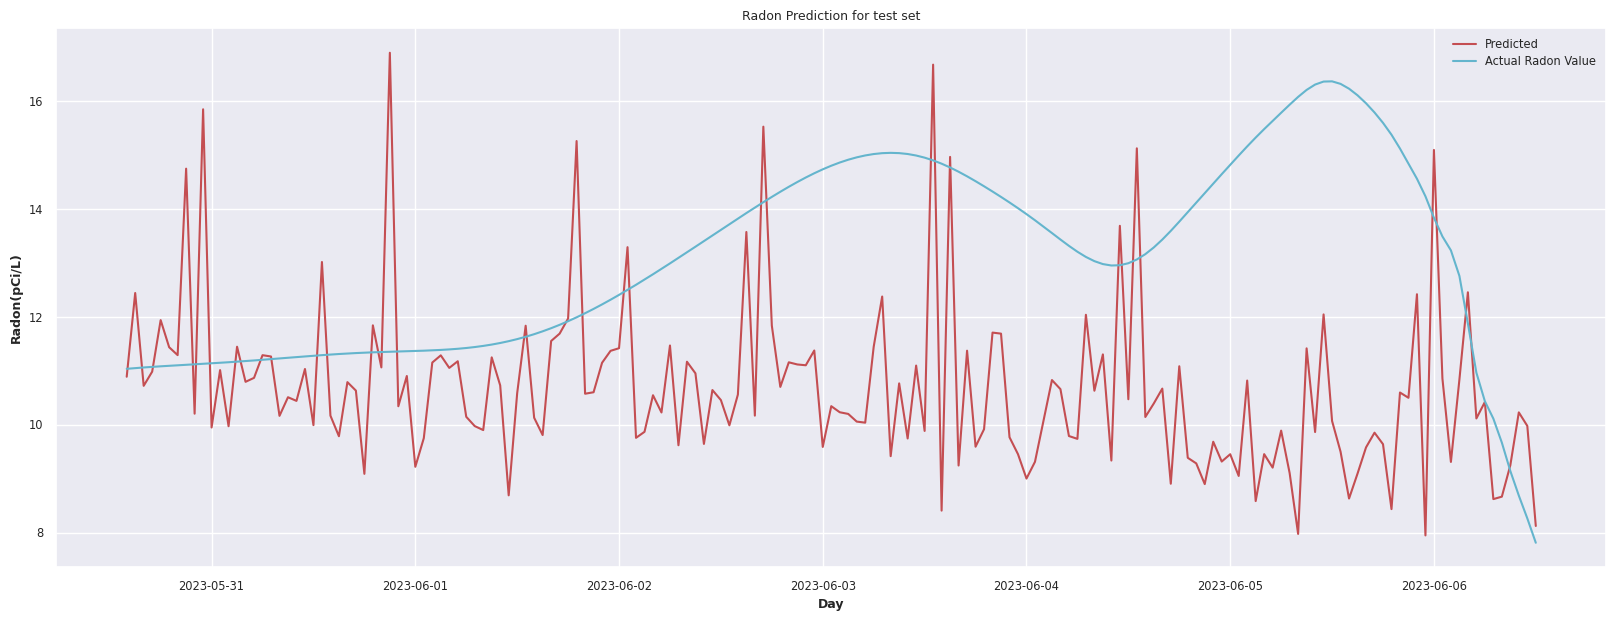

In [38]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()

# Radon 13

In [39]:
df = df_radon['13'].copy()

In [40]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [41]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

In [42]:
signal = df['Radon'].copy()
wavelet_name='coif17'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [43]:
weather_station = pd.read_csv('weather_data_combined.csv')

In [44]:
weather_station.drop('Date', axis=1, inplace=True)
weather_station['Simple Date'] = pd.to_datetime(weather_station['Simple Date'])
weather_station.sort_values(by='Simple Date', ascending=True, inplace=True)
weather_station['Simple Date'] = weather_station['Simple Date'].dt.floor('H')
weather_station = weather_station.resample('H', on = 'Simple Date').mean()
weather_station = weather_station.interpolate(method='linear', limit_direction='both')

In [45]:
weather_station

,Outdoor h Temperature (°F),Wind Speed (mph),Wind Gust (mph),Max Daily Gust (mph),Wind Direction (°),Hourly Rain (in/hr),Event Rain (in),Daily Rain (in),Weekly Rain (in),Monthly Rain (in),Yearly Rain (in),Relative Pressure (inHg),Humidity (%),Ultra-Violet Radiation Index,Solar Radiation (W/m^2),Absolute Pressure (inHg),Avg Wind Direction (10 mins) (°),Avg Wind Speed (10 mins) (mph)
Simple Date,,,,,,,,,,,,,,,,,,
2022-05-10 00:00:00,55.74,0.00,0.00,0.00,305.17,0.00,0.00,0.00,0.00,0.76,22.72,29.13,90.67,0.00,0.00,29.13,305.42,0.00
2022-05-10 01:00:00,54.79,0.00,0.00,0.00,302.58,0.00,0.00,0.00,0.00,0.76,22.72,29.12,91.58,0.00,0.00,29.12,302.67,0.00
2022-05-10 02:00:00,53.88,0.00,0.00,0.00,298.92,0.00,0.00,0.00,0.00,0.76,22.72,29.11,91.42,0.00,0.00,29.11,298.83,0.00
2022-05-10 03:00:00,52.49,0.00,0.00,0.00,302.92,0.00,0.00,0.00,0.00,0.76,22.72,29.12,92.83,0.00,0.00,29.12,302.83,0.00
2022-05-10 04:00:00,51.70,0.00,0.00,0.00,305.17,0.00,0.00,0.00,0.00,0.76,22.72,29.13,94.00,0.00,0.00,29.13,305.67,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-07 19:00:00,80.57,0.02,0.18,9.20,287.08,0.00,0.00,0.00,0.02,0.02,83.42,28.66,54.42,0.00,33.17,28.66,311.17,0.02
2023-06-07 20:00:00,77.16,0.00,0.00,9.20,309.83,0.00,0.00,0.00,0.02,0.02,83.42,28.66,58.42,0.00,5.92,28.66,310.00,0.00
2023-06-07 21:00:00,74.54,0.00,0.00,9.20,304.83,0.00,0.00,0.00,0.02,0.02,83.42,28.66,63.08,0.00,0.00,28.66,304.75,0.00


In [46]:
for column in weather_station.columns:
    df[column] = weather_station[column]

In [47]:
df

,AirPressure,Humidity,Radon,Temperature,Outdoor h Temperature (°F),Wind Speed (mph),Wind Gust (mph),Max Daily Gust (mph),Wind Direction (°),Hourly Rain (in/hr),...,Weekly Rain (in),Monthly Rain (in),Yearly Rain (in),Relative Pressure (inHg),Humidity (%),Ultra-Violet Radiation Index,Solar Radiation (W/m^2),Absolute Pressure (inHg),Avg Wind Direction (10 mins) (°),Avg Wind Speed (10 mins) (mph)
SyncDate,,,,,,,,,,,,,,,,,,,,,
2022-05-11 19:00:00,30.07,62.00,5.31,76.00,77.07,0.00,0.09,5.80,313.08,0.00,...,0.00,0.76,22.72,29.00,63.75,0.00,21.24,29.00,307.25,0.00
2022-05-11 20:00:00,30.07,66.00,5.17,75.00,74.87,0.00,0.00,5.80,302.08,0.00,...,0.00,0.76,22.72,29.01,68.42,0.00,2.57,29.01,301.17,0.00
2022-05-11 21:00:00,30.07,70.00,5.02,73.00,72.88,0.00,0.00,5.80,301.67,0.00,...,0.00,0.76,22.72,29.02,73.75,0.00,0.00,29.02,302.17,0.00
2022-05-11 22:00:00,30.08,73.00,4.87,71.00,71.14,0.00,0.00,5.80,306.00,0.00,...,0.00,0.76,22.72,29.05,73.75,0.00,0.00,29.05,305.83,0.00
2022-05-11 23:00:00,30.11,72.00,4.70,70.00,69.29,0.00,0.00,5.80,301.50,0.00,...,0.00,0.76,22.72,29.06,74.58,0.00,0.00,29.06,304.08,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06 08:00:00,30.01,87.00,5.77,68.00,69.51,0.29,1.03,2.25,307.83,0.00,...,0.02,0.02,83.42,28.89,86.08,0.42,104.46,28.89,307.00,0.09
2023-06-06 09:00:00,30.00,85.00,5.71,71.00,76.43,0.43,1.67,4.80,317.17,0.00,...,0.02,0.02,83.42,28.90,74.75,2.75,333.82,28.90,311.42,0.35
2023-06-06 10:00:00,30.01,77.00,5.64,80.00,81.18,0.68,2.05,6.17,308.50,0.00,...,0.02,0.02,83.42,28.89,68.08,5.00,547.11,28.89,315.25,0.57


In [48]:
df.dropna(inplace=True)

In [49]:
df

,AirPressure,Humidity,Radon,Temperature,Outdoor h Temperature (°F),Wind Speed (mph),Wind Gust (mph),Max Daily Gust (mph),Wind Direction (°),Hourly Rain (in/hr),...,Weekly Rain (in),Monthly Rain (in),Yearly Rain (in),Relative Pressure (inHg),Humidity (%),Ultra-Violet Radiation Index,Solar Radiation (W/m^2),Absolute Pressure (inHg),Avg Wind Direction (10 mins) (°),Avg Wind Speed (10 mins) (mph)
SyncDate,,,,,,,,,,,,,,,,,,,,,
2022-05-11 19:00:00,30.07,62.00,5.31,76.00,77.07,0.00,0.09,5.80,313.08,0.00,...,0.00,0.76,22.72,29.00,63.75,0.00,21.24,29.00,307.25,0.00
2022-05-11 20:00:00,30.07,66.00,5.17,75.00,74.87,0.00,0.00,5.80,302.08,0.00,...,0.00,0.76,22.72,29.01,68.42,0.00,2.57,29.01,301.17,0.00
2022-05-11 21:00:00,30.07,70.00,5.02,73.00,72.88,0.00,0.00,5.80,301.67,0.00,...,0.00,0.76,22.72,29.02,73.75,0.00,0.00,29.02,302.17,0.00
2022-05-11 22:00:00,30.08,73.00,4.87,71.00,71.14,0.00,0.00,5.80,306.00,0.00,...,0.00,0.76,22.72,29.05,73.75,0.00,0.00,29.05,305.83,0.00
2022-05-11 23:00:00,30.11,72.00,4.70,70.00,69.29,0.00,0.00,5.80,301.50,0.00,...,0.00,0.76,22.72,29.06,74.58,0.00,0.00,29.06,304.08,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06 08:00:00,30.01,87.00,5.77,68.00,69.51,0.29,1.03,2.25,307.83,0.00,...,0.02,0.02,83.42,28.89,86.08,0.42,104.46,28.89,307.00,0.09
2023-06-06 09:00:00,30.00,85.00,5.71,71.00,76.43,0.43,1.67,4.80,317.17,0.00,...,0.02,0.02,83.42,28.90,74.75,2.75,333.82,28.90,311.42,0.35
2023-06-06 10:00:00,30.01,77.00,5.64,80.00,81.18,0.68,2.05,6.17,308.50,0.00,...,0.02,0.02,83.42,28.89,68.08,5.00,547.11,28.89,315.25,0.57


In [50]:
# any missing values?
def gaps(df):
    if df.isnull().values.any():
        print("MISSING values:\n")
        mno.matrix(df)
    else:
        print("no missing values\n")
gaps(df)

no missing values



In [51]:
df.describe()

,AirPressure,Humidity,Radon,Temperature,Outdoor h Temperature (°F),Wind Speed (mph),Wind Gust (mph),Max Daily Gust (mph),Wind Direction (°),Hourly Rain (in/hr),...,Weekly Rain (in),Monthly Rain (in),Yearly Rain (in),Relative Pressure (inHg),Humidity (%),Ultra-Violet Radiation Index,Solar Radiation (W/m^2),Absolute Pressure (inHg),Avg Wind Direction (10 mins) (°),Avg Wind Speed (10 mins) (mph)
count,9378.00,9378.00,9378.00,9378.00,9378.00,9378.00,9378.00,9378.00,9378.00,9378.00,...,9378.00,9378.00,9378.00,9378.00,9378.00,9378.00,9378.00,9378.00,9378.00,9378.00
mean,30.09,82.47,8.81,66.32,62.98,0.23,0.90,4.70,297.71,0.01,...,0.54,2.88,52.63,29.02,76.37,0.96,119.51,29.02,308.30,0.15
std,0.14,14.90,12.58,16.32,14.85,0.37,1.15,3.49,28.84,0.04,...,0.85,2.98,18.94,0.14,17.72,1.79,200.38,0.14,18.81,0.31
min,29.52,23.00,-1.36,16.00,7.12,0.00,0.00,0.00,1.33,0.00,...,0.00,0.00,22.72,28.40,17.17,0.00,0.00,28.40,1.42,0.00
25%,30.00,75.00,1.22,54.00,52.55,0.00,0.00,1.48,289.00,0.00,...,0.00,0.76,37.85,28.93,65.00,0.00,0.00,28.93,302.17,0.00
50%,30.09,88.00,4.38,67.00,64.87,0.03,0.37,4.50,305.58,0.00,...,0.09,2.14,47.13,29.02,79.92,0.00,2.59,29.02,311.08,0.00
75%,30.18,94.00,12.80,76.52,73.89,0.34,1.56,6.90,316.08,0.00,...,0.72,3.72,69.48,29.11,91.58,1.00,144.45,29.11,318.75,0.15
max,30.62,100.00,135.58,137.00,98.02,5.35,8.02,20.60,347.67,1.23,...,3.90,14.68,83.42,29.51,99.00,8.00,872.65,29.51,348.08,3.15


In [52]:
for column in df.columns:
    df[column] = df[column].astype('float32')
    if column == 'Radon':
        continue
    else:
        for i in range(1,40):
            df[column+'_lag_'+str(i)] = df[column].shift(i)

In [53]:
df.fillna(0, inplace=True)

In [54]:
# check correlations of features with price
df_corr = df.corr(method="spearman")
print(df_corr.shape)
print("correlation with Radon:")
df_corrP = pd.DataFrame(df_corr["Radon"].sort_values(ascending=False))
df_corrP

(841, 841)
correlation with Radon:


,Radon
Radon,1.00
Temperature_lag_17,0.54
Temperature_lag_18,0.54
Temperature_lag_16,0.54
Temperature,0.54
...,...
Yearly Rain (in)_lag_35,-0.64
Yearly Rain (in)_lag_36,-0.64
Yearly Rain (in)_lag_37,-0.64
Yearly Rain (in)_lag_38,-0.64


In [55]:
# highest absolute correlations with Radon
pd.options.display.float_format = '{:,.2f}'.format
df_corrH = df_corrP[(df_corrP["Radon"]) >= 0.54103]
df_corrH

,Radon
Radon,1.00
Temperature_lag_17,0.54


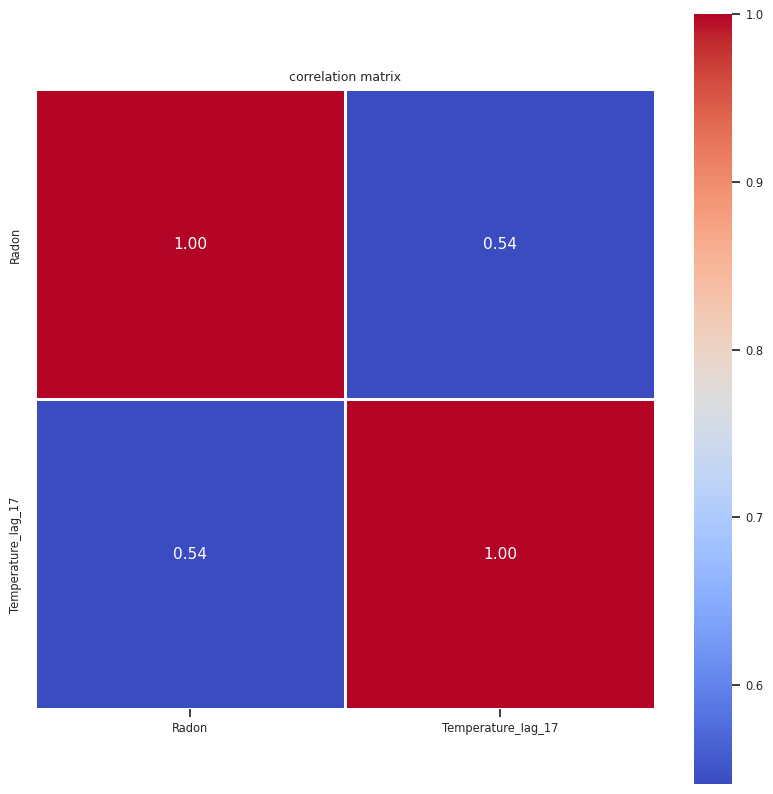

In [56]:
# helper method: correlation matrix as heatmap
def corr_heatmap(df):
    idx = df.corr().sort_values("Radon", ascending=False).index
    df_sorted = df.loc[:, idx]  # sort dataframe columns by their correlation 

    #plt.figure(figsize = (15,15))
    sns.set(font_scale=0.75)
    ax = sns.heatmap(df_sorted.corr(method='spearman').round(3), 
            annot=True, 
            square=True, 
            linewidths=.75, cmap="coolwarm", 
            fmt = ".2f", 
            annot_kws = {"size": 11})
    ax.xaxis.tick_bottom()
    plt.title("correlation matrix")
    plt.show()



# visualize correlations with price     

df4 = df[df_corrH.index]   # keep the components with at least modest correlations

plt.figure(figsize = (10,10))
corr_heatmap(df4)

In [57]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9378 entries, 2022-05-11 19:00:00 to 2023-06-06 12:00:00
Freq: H
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Radon               9378 non-null   float32
 1   Temperature_lag_17  9378 non-null   float32
dtypes: float32(2)
memory usage: 146.5 KB


In [58]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df4["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [59]:
# create time series object for the feature columns
df_covF = df4.loc[:, df4.columns != "Radon"]
df_covF = df_covF.loc[:, df_covF.columns != 'Outdoor h Temperature (°F)']
ts_covF = TimeSeries.from_dataframe(df_covF, fill_missing_dates=True, freq="H")

# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)

components (columns) of feature time series: Index(['Temperature_lag_17'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [60]:
# example: operating with time series objects:
# we can also create a 3-dimensional numpy array from a time series object
# 3 dimensions: time (rows) / components (columns) / samples
ar_covF = ts_covF.all_values()
print(type(ar_covF))
ar_covF.shape

<class 'numpy.ndarray'>


(9378, 1, 1)

In [61]:
# example: operating with time series objects:
# we can also create a pandas series or dataframe from a time series object
df_covF = ts_covF.pd_dataframe()
type(df_covF)

pandas.core.frame.DataFrame

In [62]:
# example: operating with time series objects:
# we can also create a 3-dimensional numpy array from a time series object
# 3 dimensions: time (rows) / components (columns) / samples
ar_covF = ts_covF.all_values()
print(type(ar_covF))
ar_covF.shape

<class 'numpy.ndarray'>


(9378, 1, 1)

In [63]:
# example: operating with time series objects:
# we can also create a pandas series or dataframe from a time series object
df_covF = ts_covF.pd_dataframe()
type(df_covF)

pandas.core.frame.DataFrame

In [64]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component,Radon
SyncDate,
2022-05-11 19:00:00,0.05
2023-06-06 12:00:00,0.05


In [65]:
# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(split_point=9210)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  
# covF_t = ts_covF
# covF_ttrain = covF_train
# covF_ttest = covF_test
# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component,Temperature_lag_17
SyncDate,
2022-05-11 19:00:00,0.00
2023-06-06 12:00:00,0.55


In [66]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component,Radon
SyncDate,
2022-05-11 19:00:00,0.05
2023-05-30 13:00:00,0.03


In [67]:
def set_seed(seed_value):
    import random
    import numpy as np
    import torch

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    pl.seed_everything(seed_value, workers=True)

In [68]:
import torch
from ray.air import session
from darts.utils.losses import SmapeLoss
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError
def build_fit_nlinear_model(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1
    set_seed(42)
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":-1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
    encoders={"cyclic": {"future": ["hour"]},
             'transformer':Scaler()} if model_args['include_hour'] else None
   

    model = NLinearModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="NLinear",
        shared_weights=False,
        normalize=model_args['normalize'],
        const_init=model_args['const_init'],
        use_static_covariates=False,
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        add_encoders=encoders,
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                future_covariates=covF_t,
                val_series=val_series,
                val_future_covariates=covF_t,)
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
    ts_tpred = model.predict(
                series = ts_ttrain,
                future_covariates=covF_t,
                n = len(ts_ttest),
                verbose=True
    )
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    session.report({'q_smape': q_smape})

In [69]:
def build_fit_nlinear_model_return(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1
    set_seed(42)
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "devices":1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": True,
        }
    encoders={"cyclic": {"future": ["hour"]},
             'transformer':Scaler()} if model_args['include_hour'] else None
   

    model = NLinearModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="DLinear",
        shared_weights=False,
        const_init=model_args['const_init'],
        normalize=model_args['normalize'],
        use_static_covariates=False,
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        add_encoders=encoders,
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                future_covariates=covF_t,
                val_series=val_series,
                val_future_covariates=covF_t,)
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
#     ts_tpred = model.predict(
#                 series = ts_ttrain,
#                 past_covariates=covF_t,
#                 n = len(ts_ttest),
#                 verbose=True
#     )
#     ts_q = scalerP.inverse_transform(ts_tpred)
#     q_smape = smape(ts_q, ts_test)
#     session.report({'q_smape': q_smape})
    return model

In [70]:
from ray import tune
from ray.tune import CLIReporter
# from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":"val_loss",
#         "sMAPE": "val_SymmetricMeanAbsolutePercentageError",
#     },
#     on="validation_end",
# )

early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )

#define the hyperparameter search space
config = {
    "in_len": tune.randint(8,168),#setting 168 is not a good option here as convolutions take time reducing this to 80
    "out_len":tune.randint(1,24),
    "normalize": tune.choice([True, False]),
    "const_init":tune.choice([True, False]),
    "lr": tune.loguniform(1e-5, 1e-1),
    "include_hour":tune.choice([True, False]),
    "batch_size":tune.choice([16,32,64,128,256]),
    
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape"])
resources_per_trial = {"cpu": 5, "gpu": 0.4}

num_samples = 100

algo = OptunaSearch()

algo = ConcurrencyLimiter(algo, max_concurrent=10)

scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_nlinear_model, callbacks=[early_stopper])

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric="q_smape",
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="dlinear_tune_cov",
    raise_on_failed_trial=False
)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-11 08:03:07 (running for 00:00:00.15)
Memory usage on this node: 85.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 1/100 (1 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr | include_hour   |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------|
| build_fit_nlinear_model_61716f1d | RUNN

(build_fit_nlinear_model pid=2701146) Global seed set to 42
(build_fit_nlinear_model pid=2701146) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2701146)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2701146) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2701146)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2701146) Auto select gpus: [0]
(build_fit_nlinear_model pid=2701146) GPU available: 

== Status ==
Current time: 2023-07-11 08:03:13 (running for 00:00:05.69)
Memory usage on this node: 85.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 2/100 (2 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr | include_hour   |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------|
| build_fit_nlinear_model_61716f1d | RUN

(build_fit_nlinear_model pid=2701541) Global seed set to 42
(build_fit_nlinear_model pid=2701541) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2701541)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2701541) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2701541)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2701541) Auto select gpus: [0]
(build_fit_nlinear_model pid=2701541) GPU available: 

== Status ==
Current time: 2023-07-11 08:03:19 (running for 00:00:11.71)
Memory usage on this node: 81.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 3/100 (3 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr | include_hour   |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------|
| build_fit_nlinear_model

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,q_smape,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
build_fit_nlinear_model_0067b3ed,2023-07-11_08-06-16,,,819fd9524ddf493990c376b1c8f82b99,,ip-172-31-10-87,,172.31.10.87,2716617,,,,,1689062776,,,,0067b3ed,
build_fit_nlinear_model_01de175d,2023-07-11_08-07-51,,,f5da10896fd04e3aaa3501d24168830e,,ip-172-31-10-87,,172.31.10.87,2729314,,,,,1689062871,,,,01de175d,
build_fit_nlinear_model_027d4f02,2023-07-11_08-05-31,True,,2dd276d3ac374240a1001a1ec11e6220,"24_batch_size=16,const_init=False,in_len=11,include_hour=False,lr=0.0268,normalize=False,out_len=19",ip-172-31-10-87,1,172.31.10.87,2710145,106.50018453598022,41.8997368812561,41.8997368812561,41.8997368812561,1689062731,0,,1,027d4f02,0.0039031505584716797
build_fit_nlinear_model_05be3ea8,2023-07-11_08-06-35,,,a99431106dc64c0ebce3165b5a1dfb6a,,ip-172-31-10-87,,172.31.10.87,2718994,,,,,1689062795,,,,05be3ea8,
build_fit_nlinear_model_07515dae,2023-07-11_08-04-13,True,,7137400caa634a46a4c0f1d2214c3bca,"7_batch_size=64,const_init=False,in_len=88,include_hour=False,lr=0.0051,normalize=False,out_len=4",ip-172-31-10-87,1,172.31.10.87,2703077,141.6854977607727,42.026307582855225,42.026307582855225,42.026307582855225,1689062653,0,,1,07515dae,0.0031921863555908203
build_fit_nlinear_model_0d8344d1,2023-07-11_08-07-16,,,c3eef11edf85409fb16370984f1fcacf,,ip-172-31-10-87,,172.31.10.87,2724207,,,,,1689062836,,,,0d8344d1,
build_fit_nlinear_model_0dd70704,2023-07-11_08-06-25,,,032e829283964be38052a10e57869386,,ip-172-31-10-87,,172.31.10.87,2718033,,,,,1689062785,,,,0dd70704,
build_fit_nlinear_model_167febe4,2023-07-11_08-04-58,,,4f068ef7e82e4411bd6f4e4412436240,,ip-172-31-10-87,,172.31.10.87,2711023,,,,,1689062698,,,,167febe4,
build_fit_nlinear_model_1ad252fa,2023-07-11_08-07-31,,,f583c83282ad4ce1a287da41da45d8e2,,ip-172-31-10-87,,172.31.10.87,2725716,,,,,1689062851,,,,1ad252fa,
build_fit_nlinear_model_1b801fc7,2023-07-11_08-06-54,,,01e8f4d221c14fdd851374feb0774a1f,,ip-172-31-10-87,,172.31.10.87,2721473,,,,,1689062814,,,,1b801fc7,


== Status ==
Current time: 2023-07-11 08:03:24 (running for 00:00:17.33)
Memory usage on this node: 90.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 4/100 (1 ERROR, 1 PENDING, 2 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr | include_hour   |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------|
| build_fit_nlinear_

(build_fit_nlinear_model pid=2702390) Global seed set to 42
(build_fit_nlinear_model pid=2702390) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2702390)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2702390) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2702390)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2702390) Auto select gpus: [0]
(build_fit_nlinear_model pid=2702390) GPU available: 

== Status ==
Current time: 2023-07-11 08:03:29 (running for 00:00:22.46)
Memory usage on this node: 93.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 10/100 (1 ERROR, 1 PENDING, 8 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr | include_hour   |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------|
| bu

(build_fit_nlinear_model pid=2703080) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2703080)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2703080) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2703080)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2703075) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecat

(build_fit_nlinear_model pid=2703069) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2703069)   rank_zero_warn(
(build_fit_nlinear_model pid=2703069) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2703069)   rank_zero_warn(
(build_fit_nlinear_model pid=2703069) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

== Status ==
Current time: 2023-07-11 08:03:39 (running for 00:00:32.29)
Memory usage on this node: 100.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 12/100 (3 ERROR, 1 PENDING, 8 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr | include_hour   |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------|
| b

(build_fit_nlinear_model pid=2704478) Global seed set to 42
(build_fit_nlinear_model pid=2704478) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2704478)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2704478) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2704478)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2704476) Auto select gpus: [0]
(build_fit_nlinear_model pid=2704476) GPU available: 

== Status ==
Current time: 2023-07-11 08:03:49 (running for 00:00:42.27)
Memory usage on this node: 102.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 13/100 (4 ERROR, 1 PENDING, 8 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr | include_hour   |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------|
| b

(build_fit_nlinear_model pid=2704958) Global seed set to 42
(build_fit_nlinear_model pid=2704958) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2704958)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2704958) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2704958)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2704958) Auto select gpus: [0]
(build_fit_nlinear_model pid=2704958) GPU available: 

== Status ==
Current time: 2023-07-11 08:03:54 (running for 00:00:47.55)
Memory usage on this node: 100.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4e71a2ae with q_smape=181.804621219635 and parameters={'in_len': 117, 'out_len': 14, 'normalize': False, 'const_init': True, 'lr': 0.011034772585277134, 'include_hour': False, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 13/100 (4 ERROR, 1 PENDING, 8 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_i

(build_fit_nlinear_model pid=2703072) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2703072) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2703072) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2703072) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2703072) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2703072) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.41it/s]


(build_fit_nlinear_model pid=2703080) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2703080)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2703080) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2703080)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2703080) Auto select gpus: [0]
(build_fit_nlinear_model pid=2703080) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2703080

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.04it/s]
== Status ==
Current time: 2023-07-11 08:04:00 (running for 00:00:52.76)
Memory usage on this node: 98.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 890ca4fa with q_smape=144.4139003753662 and parameters={'in_len': 146, 'out_len': 11, 'normalize': False, 'const_init': True, 'lr': 5.20805781299677e-05, 'include_hour': True, 'batch_size': 32}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 14/100 (4 ERROR, 1 PENDING, 8 RUNNING, 1 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                

(build_fit_nlinear_model pid=2702390) Auto select gpus: [0]
(build_fit_nlinear_model pid=2702390) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2702390) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2702390) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2702390) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2702390) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2702390) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 210.74it/s]


(build_fit_nlinear_model pid=2705544) Global seed set to 42
(build_fit_nlinear_model pid=2705544) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2705544)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2705544) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2705544)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2705544) Auto select gpus: [0]
(build_fit_nlinear_model pid=2705544) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 210.46it/s]


(build_fit_nlinear_model pid=2704476) Auto select gpus: [0]
(build_fit_nlinear_model pid=2704476) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2704476) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2704476) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2704476) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2704476) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2704476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-11 08:04:07 (running for 00:01:00.18)
Memory usage on this node: 96.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 6d4a649f with q_smape=142.39050149917603 and parameters={'in_len': 156, 'out_len': 14, 'normalize': False, 'const_init': True, 'lr': 0.00011364817976840534, 'include_hour': False, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 16/100 (4 ERROR, 1 PENDING, 8 RUNNING, 3 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len |

(build_fit_nlinear_model pid=2706185) Global seed set to 42
(build_fit_nlinear_model pid=2706183) Global seed set to 42
(build_fit_nlinear_model pid=2706183) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2706183)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2706183) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2706183)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2706185) /home/ubuntu/an

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.45it/s]


(build_fit_nlinear_model pid=2706185) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2706185)   rank_zero_warn(
(build_fit_nlinear_model pid=2706185) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2706185)   rank_zero_warn(
(build_fit_nlinear_model pid=2706185) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.20it/s]
== Status ==
Current time: 2023-07-11 08:04:12 (running for 00:01:05.27)
Memory usage on this node: 93.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 6d4a649f with q_smape=142.39050149917603 and parameters={'in_len': 156, 'out_len': 14, 'normalize': False, 'const_init': True, 'lr': 0.00011364817976840534, 'include_hour': False, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 16/100 (4 ERROR, 8 RUNNING, 4 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                      

(build_fit_nlinear_model pid=2707206) Global seed set to 42
(build_fit_nlinear_model pid=2707206) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2707206)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2707206) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2707206)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2707206) Auto select gpus: [0]
(build_fit_nlinear_model pid=2707206) GPU available: 

== Status ==
Current time: 2023-07-11 08:04:24 (running for 00:01:17.32)
Memory usage on this node: 95.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 07515dae with q_smape=141.6854977607727 and parameters={'in_len': 88, 'out_len': 4, 'normalize': False, 'const_init': False, 'lr': 0.005070850338192058, 'include_hour': False, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 20/100 (5 ERROR, 1 PENDING, 8 RUNNING, 6 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | norm

(build_fit_nlinear_model pid=2708152) Global seed set to 42
(build_fit_nlinear_model pid=2708156) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2708156)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2708156) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2708156)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2708152) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/traine

(build_fit_nlinear_model pid=2708156) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2708156)   rank_zero_warn(
(build_fit_nlinear_model pid=2708156) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2708156)   rank_zero_warn(
(build_fit_nlinear_model pid=2704958) Auto select gpus: [0]
(build_fit_nlinear_model pid=2704958) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2704958) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2704958) IPU availab

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.53it/s]


(build_fit_nlinear_model pid=2709301) Global seed set to 42
(build_fit_nlinear_model pid=2709301) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2709301)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2709301) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2709301)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:04:32 (running for 00:01:25.20)
Memory usage on this node: 98.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 07515dae with q_smape=141.6854977607727 and parameters={'in_len': 88, 'out_len': 4, 'normalize': False, 'const_init': False, 'lr': 0.005070850338192058, 'include_hour': False, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 22/100 (7 ERROR, 1 PENDING, 8 RUNNING, 6 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | norm

(build_fit_nlinear_model pid=2709299) Global seed set to 42
(build_fit_nlinear_model pid=2709299) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2709299)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2709299) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2709299)   rank_zero_deprecation(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.75it/s]


(build_fit_nlinear_model pid=2706185) Auto select gpus: [0]
(build_fit_nlinear_model pid=2706185) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2706185) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2706185) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2706185) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2706185) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2706185) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2709301) Auto select gpus: [0]
(build_fit_nlinear_model pid=2709301) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 222.29it/s]


(build_fit_nlinear_model pid=2709299) Auto select gpus: [0]
(build_fit_nlinear_model pid=2709299) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2709299) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2709299) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2709299) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2709299) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2709299) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2709299) 
(build_fit_nlinear_model pid=2709299)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2709299) ----

== Status ==
Current time: 2023-07-11 08:04:37 (running for 00:01:30.27)
Memory usage on this node: 98.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 07515dae with q_smape=141.6854977607727 and parameters={'in_len': 88, 'out_len': 4, 'normalize': False, 'const_init': False, 'lr': 0.005070850338192058, 'include_hour': False, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 22/100 (7 ERROR, 6 RUNNING, 9 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |  

(build_fit_nlinear_model pid=2709903) Global seed set to 42
(build_fit_nlinear_model pid=2709903) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2709903)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2709903) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2709903)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2709903) Auto select gpus: [0]
(build_fit_nlinear_model pid=2709903) GPU available: 

== Status ==
Current time: 2023-07-11 08:04:48 (running for 00:01:40.77)
Memory usage on this node: 96.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 07515dae with q_smape=141.6854977607727 and parameters={'in_len': 88, 'out_len': 4, 'normalize': False, 'const_init': False, 'lr': 0.005070850338192058, 'include_hour': False, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 26/100 (8 ERROR, 1 PENDING, 8 RUNNING, 9 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | norm

(build_fit_nlinear_model pid=2710145) Global seed set to 42
(build_fit_nlinear_model pid=2710145) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2710145)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2710145) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2710145)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2710142) Auto select gpus: [0]
(build_fit_nlinear_model pid=2710142) GPU available: 

(build_fit_nlinear_model pid=2710145) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2710145)   rank_zero_warn(
(build_fit_nlinear_model pid=2710145) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2710145)   rank_zero_warn(
(build_fit_nlinear_model pid=2710145) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

== Status ==
Current time: 2023-07-11 08:04:57 (running for 00:01:50.29)
Memory usage on this node: 100.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 07515dae with q_smape=141.6854977607727 and parameters={'in_len': 88, 'out_len': 4, 'normalize': False, 'const_init': False, 'lr': 0.005070850338192058, 'include_hour': False, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 27/100 (9 ERROR, 1 PENDING, 8 RUNNING, 9 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | nor

(build_fit_nlinear_model pid=2711023) Global seed set to 42
(build_fit_nlinear_model pid=2711023) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2711023)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2711023) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2711023)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2711023) Auto select gpus: [0]
(build_fit_nlinear_model pid=2711023) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 231.33it/s]


(build_fit_nlinear_model pid=2708156) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2708156)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2708156) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2708156)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2708156) Auto select gpus: [0]
(build_fit_nlinear_model pid=2708156) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2708156

== Status ==
Current time: 2023-07-11 08:05:05 (running for 00:01:57.96)
Memory usage on this node: 100.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 28/100 (10 ERROR, 1 PENDING, 8 RUNNING, 9 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len |

(build_fit_nlinear_model pid=2711578) Global seed set to 42
(build_fit_nlinear_model pid=2711578) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2711578)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2711578) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2711578)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2711578) Auto select gpus: [0]
(build_fit_nlinear_model pid=2711578) GPU available: 

== Status ==
Current time: 2023-07-11 08:05:11 (running for 00:02:04.02)
Memory usage on this node: 101.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 29/100 (11 ERROR, 1 PENDING, 7 RUNNING, 10 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   |

(build_fit_nlinear_model pid=2711982) Global seed set to 42
(build_fit_nlinear_model pid=2711982) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2711982)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2711982) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2711982)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2711982) Auto select gpus: [0]
(build_fit_nlinear_model pid=2711982) GPU available: 

== Status ==
Current time: 2023-07-11 08:05:19 (running for 00:02:12.31)
Memory usage on this node: 102.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 30/100 (11 ERROR, 1 PENDING, 8 RUNNING, 10 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len 

(build_fit_nlinear_model pid=2712298) Global seed set to 42
(build_fit_nlinear_model pid=2712298) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2712298)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2712298) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2712298)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2712298) Auto select gpus: [0]
(build_fit_nlinear_model pid=2712298) GPU available: 

== Status ==
Current time: 2023-07-11 08:05:27 (running for 00:02:20.31)
Memory usage on this node: 100.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 31/100 (12 ERROR, 1 PENDING, 8 RUNNING, 10 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len 

(build_fit_nlinear_model pid=2712547) Global seed set to 42
(build_fit_nlinear_model pid=2712547) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2712547)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2712547) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2712547)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2712547) Auto select gpus: [0]
(build_fit_nlinear_model pid=2712547) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.64it/s]


(build_fit_nlinear_model pid=2710145) Auto select gpus: [0]
(build_fit_nlinear_model pid=2710145) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2710145) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2710145) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2710145) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2710145) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2710145) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2713200) Global seed set to 42
(build_fit_nlinear_model pid=2713200) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:05:32 (running for 00:02:25.31)
Memory usage on this node: 98.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 32/100 (13 ERROR, 8 RUNNING, 11 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize 

(build_fit_nlinear_model pid=2713197) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2713197)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2713197) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2713197)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2713200) Auto select gpus: [0]
(build_fit_nlinear_model pid=2713200) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2713200

== Status ==
Current time: 2023-07-11 08:05:41 (running for 00:02:33.95)
Memory usage on this node: 104.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 33/100 (14 ERROR, 1 PENDING, 7 RUNNING, 11 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   |

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.58it/s]


(build_fit_nlinear_model pid=2711982) Auto select gpus: [0]
(build_fit_nlinear_model pid=2711982) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2711982) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2711982) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2711982) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2711982) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2711982) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2713795) Global seed set to 42
(build_fit_nlinear_model pid=2713795) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:05:48 (running for 00:02:41.30)
Memory usage on this node: 100.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 36/100 (15 ERROR, 1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len 

(build_fit_nlinear_model pid=2714111) Global seed set to 42
(build_fit_nlinear_model pid=2714111) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2714111)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2714111) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2714111)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2714111) Auto select gpus: [0]
(build_fit_nlinear_model pid=2714111) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.38it/s]


(build_fit_nlinear_model pid=2707206) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2707206)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2707206) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2707206)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2707206) Auto select gpus: [0]
(build_fit_nlinear_model pid=2707206) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2707206

== Status ==
Current time: 2023-07-11 08:05:53 (running for 00:02:46.31)
Memory usage on this node: 98.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 39/100 (18 ERROR, 1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len |

(build_fit_nlinear_model pid=2714504) Auto select gpus: [0]
(build_fit_nlinear_model pid=2714504) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2714504) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2714504) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2714504) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2714504) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2714504) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2714504) 
(build_fit_nlinear_model pid=2714504)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2714504) ----

== Status ==
Current time: 2023-07-11 08:05:58 (running for 00:02:51.36)
Memory usage on this node: 100.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 39/100 (18 ERROR, 1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len 

(build_fit_nlinear_model pid=2714757) Global seed set to 42
(build_fit_nlinear_model pid=2714757) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2714757)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2714757) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2714757)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2714506) Auto select gpus: [0]
(build_fit_nlinear_model pid=2714506) GPU available: 

== Status ==
Current time: 2023-07-11 08:06:06 (running for 00:02:59.33)
Memory usage on this node: 93.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 44/100 (21 ERROR, 1 PENDING, 8 RUNNING, 14 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len |

(build_fit_nlinear_model pid=2715608) Global seed set to 42
(build_fit_nlinear_model pid=2715608) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2715608)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2715608) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2715608)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2715221) Auto select gpus: [0]
(build_fit_nlinear_model pid=2715221) GPU available: 

(build_fit_nlinear_model pid=2715608) Auto select gpus: [0]
(build_fit_nlinear_model pid=2715608) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2715608) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2715608) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2715608) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2715608) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2715608) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2715608) 
(build_fit_nlinear_model pid=2715608)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2715608) ----

== Status ==
Current time: 2023-07-11 08:06:15 (running for 00:03:08.31)
Memory usage on this node: 95.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 49/100 (26 ERROR, 1 PENDING, 8 RUNNING, 14 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len |

(build_fit_nlinear_model pid=2717055) Global seed set to 42
(build_fit_nlinear_model pid=2717055) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2717055)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2717055) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2717055)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2716666) Auto select gpus: [0]
(build_fit_nlinear_model pid=2716666) GPU available: 

(build_fit_nlinear_model pid=2717816) Global seed set to 42
(build_fit_nlinear_model pid=2717816) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2717816)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2717816) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2717816)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2718033) Global seed set to 42
(build_fit_nlinear_model pid=2718033) /home/ubuntu/an

== Status ==
Current time: 2023-07-11 08:06:24 (running for 00:03:17.41)
Memory usage on this node: 95.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 54/100 (31 ERROR, 1 PENDING, 8 RUNNING, 14 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len |

(build_fit_nlinear_model pid=2717983) Global seed set to 42
(build_fit_nlinear_model pid=2717983) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2717983)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2717983) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2717983)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2717816) Auto select gpus: [0]
(build_fit_nlinear_model pid=2717816) GPU available: 

(build_fit_nlinear_model pid=2717983) Auto select gpus: [0]
(build_fit_nlinear_model pid=2717983) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2717983) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2717983) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2717983) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2717983) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2717983) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2717983) 
(build_fit_nlinear_model pid=2717983)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2717983) ----

== Status ==
Current time: 2023-07-11 08:06:29 (running for 00:03:22.43)
Memory usage on this node: 93.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 58/100 (36 ERROR, 8 RUNNING, 14 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize 

(build_fit_nlinear_model pid=2718992) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2718992)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2718992) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2718992)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2718996) Global seed set to 42
(build_fit_nlinear_model pid=2718996) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/traine

== Status ==
Current time: 2023-07-11 08:06:38 (running for 00:03:31.05)
Memory usage on this node: 103.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 59/100 (37 ERROR, 1 PENDING, 7 RUNNING, 14 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   |

(build_fit_nlinear_model pid=2720149) Global seed set to 42
(build_fit_nlinear_model pid=2720151) Global seed set to 42
(build_fit_nlinear_model pid=2720149) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2720149)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2720149) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2720149)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2720151) /home/ubuntu/an

== Status ==
Current time: 2023-07-11 08:06:44 (running for 00:03:37.41)
Memory usage on this node: 95.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 64/100 (41 ERROR, 1 PENDING, 8 RUNNING, 14 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len |

(build_fit_nlinear_model pid=2720406) Global seed set to 42
(build_fit_nlinear_model pid=2720406) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2720406)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2720406) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2720406)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2720149) Auto select gpus: [0]
(build_fit_nlinear_model pid=2720149) GPU available: 

(build_fit_nlinear_model pid=2720406) Auto select gpus: [0]
(build_fit_nlinear_model pid=2720406) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2720406) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2720406) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2720406) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2720406) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2720406) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2720406) 
(build_fit_nlinear_model pid=2720406)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2720406) ----

== Status ==
Current time: 2023-07-11 08:06:54 (running for 00:03:47.32)
Memory usage on this node: 96.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 69/100 (46 ERROR, 1 PENDING, 8 RUNNING, 14 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len |

(build_fit_nlinear_model pid=2721934) Global seed set to 42
(build_fit_nlinear_model pid=2721934) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2721934)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2721934) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2721934)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2721477) Auto select gpus: [0]
(build_fit_nlinear_model pid=2721477) GPU available: 

(build_fit_nlinear_model pid=2703069) Auto select gpus: [0]
(build_fit_nlinear_model pid=2703069) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2703069) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2703069) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2703069) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2703069) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2703069) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.91it/s]


(build_fit_nlinear_model pid=2722485) Global seed set to 42
(build_fit_nlinear_model pid=2722485) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2722485)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2722485) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2722485)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2722536) Global seed set to 42
(build_fit_nlinear_model pid=2722536) /home/ubuntu/an

== Status ==
Current time: 2023-07-11 08:06:59 (running for 00:03:52.41)
Memory usage on this node: 94.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 74/100 (51 ERROR, 1 PENDING, 8 RUNNING, 14 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len |

(build_fit_nlinear_model pid=2722927) Global seed set to 42
(build_fit_nlinear_model pid=2722927) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2722927)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2722927) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2722927)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2722485) Auto select gpus: [0]
(build_fit_nlinear_model pid=2722485) GPU available: 

(build_fit_nlinear_model pid=2722927) Auto select gpus: [0]
(build_fit_nlinear_model pid=2722927) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2722927) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2722927) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2722927) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2722927) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2722927) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2722927) 
(build_fit_nlinear_model pid=2722927)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2722927) ----

== Status ==
Current time: 2023-07-11 08:07:06 (running for 00:03:58.93)
Memory usage on this node: 99.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 75/100 (52 ERROR, 1 PENDING, 7 RUNNING, 15 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | 

(build_fit_nlinear_model pid=2723795) Global seed set to 42
(build_fit_nlinear_model pid=2723795) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2723795)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2723795) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2723795)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2723795) Auto select gpus: [0]
(build_fit_nlinear_model pid=2723795) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.00it/s]


(build_fit_nlinear_model pid=2724207) Global seed set to 42
(build_fit_nlinear_model pid=2724207) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2724207)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2724207) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2724207)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2724211) Global seed set to 42


== Status ==
Current time: 2023-07-11 08:07:13 (running for 00:04:05.79)
Memory usage on this node: 94.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 80/100 (57 ERROR, 1 PENDING, 7 RUNNING, 15 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | 

(build_fit_nlinear_model pid=2724211) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2724211)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2724211) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2724211)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2724209) Global seed set to 42
(build_fit_nlinear_model pid=2724309) Global seed set to 42
(build_fit_nlinear_model pid=2724209) /home/ubuntu/an

(build_fit_nlinear_model pid=2724209) Auto select gpus: [0]
(build_fit_nlinear_model pid=2724209) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2724209) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2724209) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2724209) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2724209) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2724209) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2724209) 
(build_fit_nlinear_model pid=2724209)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2724209) ----

== Status ==
Current time: 2023-07-11 08:07:18 (running for 00:04:11.31)
Memory usage on this node: 97.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 80/100 (57 ERROR, 7 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init 

(build_fit_nlinear_model pid=2725369) Global seed set to 42


== Status ==
Current time: 2023-07-11 08:07:24 (running for 00:04:16.65)
Memory usage on this node: 100.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 81/100 (58 ERROR, 1 PENDING, 6 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   |

(build_fit_nlinear_model pid=2725369) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2725369)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2725369) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2725369)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2725369) Auto select gpus: [0]
(build_fit_nlinear_model pid=2725369) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2725369

(build_fit_nlinear_model pid=2725610) Auto select gpus: [0]
(build_fit_nlinear_model pid=2725610) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2725610) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2725610) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2725610) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2725610) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2725610) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2725610) 
(build_fit_nlinear_model pid=2725610)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2725610) ----

(build_fit_nlinear_model pid=2725716) Auto select gpus: [0]
(build_fit_nlinear_model pid=2725716) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2725716) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2725716) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2725716) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2725716) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2725716) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2725716) 
(build_fit_nlinear_model pid=2725716)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2725716) ----

== Status ==
Current time: 2023-07-11 08:07:32 (running for 00:04:25.33)
Memory usage on this node: 95.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 88/100 (63 ERROR, 1 PENDING, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len |

(build_fit_nlinear_model pid=2726560) Global seed set to 42
(build_fit_nlinear_model pid=2726560) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2726560)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2726560) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2726560)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2726560) Auto select gpus: [0]
(build_fit_nlinear_model pid=2726560) GPU available: 

(build_fit_nlinear_model pid=2727680) Auto select gpus: [0]
(build_fit_nlinear_model pid=2727680) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2727680) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2727680) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2727680) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2727680) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2727680) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2727680) 
(build_fit_nlinear_model pid=2727680)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2727680) ----

== Status ==
Current time: 2023-07-11 08:07:42 (running for 00:04:35.32)
Memory usage on this node: 97.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 95/100 (71 ERROR, 1 PENDING, 7 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | 

(build_fit_nlinear_model pid=2728411) Global seed set to 42
(build_fit_nlinear_model pid=2728411) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2728411)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2728411) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2728411)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2728411) Auto select gpus: [0]
(build_fit_nlinear_model pid=2728411) GPU available: 

(build_fit_nlinear_model pid=2729262) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2729262)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2729262) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2729262)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:07:51 (running for 00:04:44.45)
Memory usage on this node: 94.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (77 ERROR, 7 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init

(build_fit_nlinear_model pid=2729312) Auto select gpus: [0]
(build_fit_nlinear_model pid=2729312) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2729312) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2729312) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2729312) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2729312) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2729312) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2729312) 
(build_fit_nlinear_model pid=2729312)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2729312) ----

(build_fit_nlinear_model pid=2729262) Auto select gpus: [0]
(build_fit_nlinear_model pid=2729262) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2729262) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2729262) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2729262) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2729262) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2729262) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2729262) 
(build_fit_nlinear_model pid=2729262)   | Name           | Type             | Params
(build_fit_nlinear_model pid=2729262) ----

== Status ==
Current time: 2023-07-11 08:07:59 (running for 00:04:51.92)
Memory usage on this node: 89.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (83 ERROR, 1 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init 

== Status ==
Current time: 2023-07-11 08:08:04 (running for 00:04:56.94)
Memory usage on this node: 87.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (83 ERROR, 1 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init 

== Status ==
Current time: 2023-07-11 08:08:09 (running for 00:05:01.97)
Memory usage on this node: 88.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (83 ERROR, 1 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init 

== Status ==
Current time: 2023-07-11 08:08:14 (running for 00:05:06.98)
Memory usage on this node: 89.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (83 ERROR, 1 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init 

== Status ==
Current time: 2023-07-11 08:08:19 (running for 00:05:12.00)
Memory usage on this node: 87.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (83 ERROR, 1 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init 

== Status ==
Current time: 2023-07-11 08:08:24 (running for 00:05:17.01)
Memory usage on this node: 87.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (83 ERROR, 1 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init 

== Status ==
Current time: 2023-07-11 08:08:29 (running for 00:05:22.03)
Memory usage on this node: 83.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (83 ERROR, 1 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init 

== Status ==
Current time: 2023-07-11 08:08:34 (running for 00:05:27.05)
Memory usage on this node: 86.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (83 ERROR, 1 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init 

== Status ==
Current time: 2023-07-11 08:08:39 (running for 00:05:32.06)
Memory usage on this node: 89.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (83 ERROR, 1 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init 

== Status ==
Current time: 2023-07-11 08:08:44 (running for 00:05:37.07)
Memory usage on this node: 87.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 34d9025b with q_smape=81.01416230201721 and parameters={'in_len': 148, 'out_len': 16, 'normalize': False, 'const_init': False, 'lr': 0.0011924560072177242, 'include_hour': True, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (83 ERROR, 1 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init 

(build_fit_nlinear_model pid=2710147) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2710147)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2710147) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2710147)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2710147) Auto select gpus: [0]
(build_fit_nlinear_model pid=2710147) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2710147

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 251.35it/s]
== Status ==
Current time: 2023-07-11 08:08:45 (running for 00:05:38.32)
Memory usage on this node: 87.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/48 CPUs, 0/4 GPUs, 0.0/62.61 GiB heap, 0.0/30.83 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3a01ac5e with q_smape=37.33105957508087 and parameters={'in_len': 45, 'out_len': 18, 'normalize': False, 'const_init': True, 'lr': 9.102212669824107e-05, 'include_hour': True, 'batch_size': 32}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (83 ERROR, 17 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+----------------+--------------+-----------+
| Trial name                       | status     | loc              

In [71]:
analysis.best_config

{'in_len': 45,
 'out_len': 18,
 'normalize': False,
 'const_init': True,
 'lr': 9.102212669824107e-05,
 'include_hour': True,
 'batch_size': 32}

In [72]:
early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )
best_model = build_fit_nlinear_model_return(analysis.best_config, callbacks=[early_stopper])

/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  rank_zero_deprecation(


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [73]:
ts_tpred = best_model.predict(
                series = ts_ttrain,
                future_covariates=covF_t,
                n = len(ts_ttest),
                verbose=True
    )

/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  rank_zero_deprecation(


Predicting: 0it [00:00, ?it/s]

In [74]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tpred = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tpred)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tpred, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 37.33105957508087


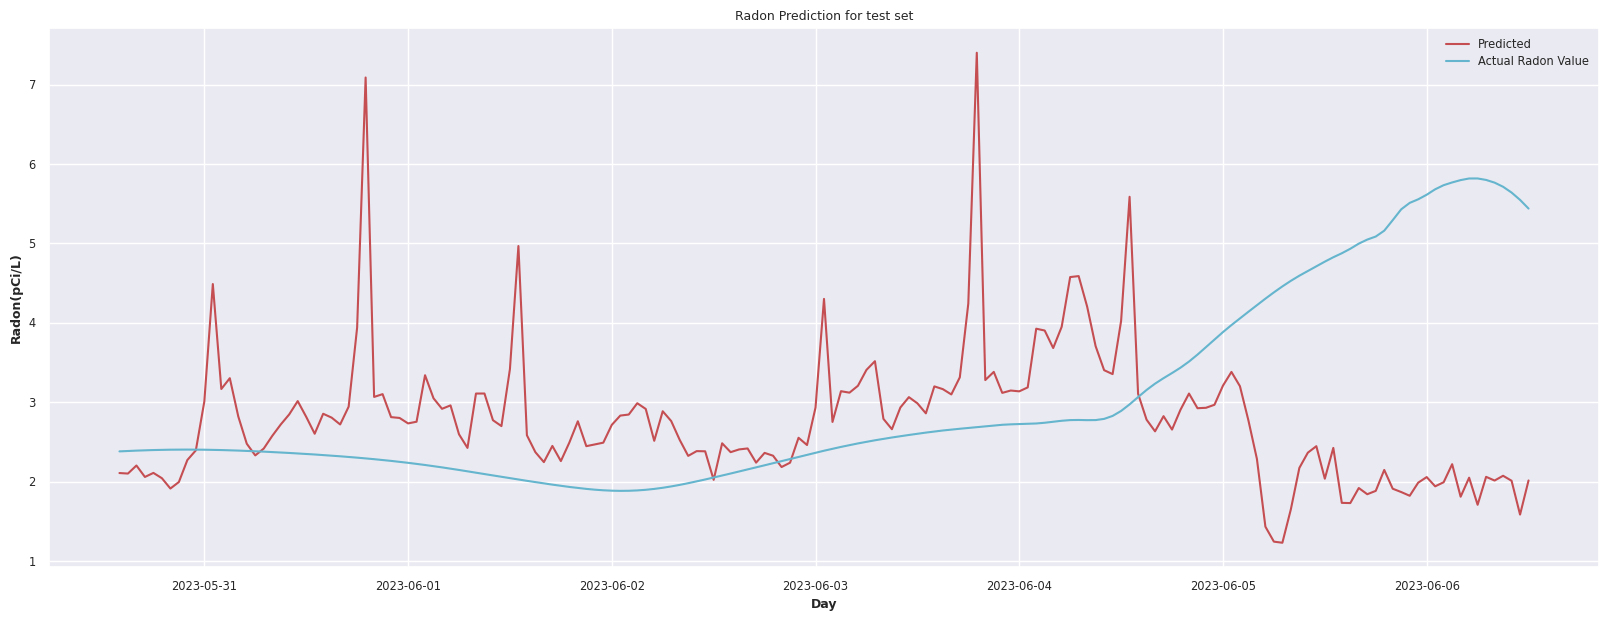

In [75]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()